# Project: Investigate European Soccer Database

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction
* European Soccer Database consists of multiple tables in **".sqlite"** format
* The database has recorded information about 25,000 matches from 2008 to 2016
* The matches are from local leagues not from European competations like UCL or UEL
* The database contains players attributes sourced from EA Sports FIFA 

> Let's explore the database to explore the followins 
> * Which teams improved through the years?
> * Compare home and away records for European teams.
> * Find which teams scored the most goals, both in home and away from home.
> * Explore Players with most wins and which attributes they have.
> * Compare different teams through different eras/seasons to know which was the strongest; like Sir Alex Ferguson's Manchester United in 2008/09, Carlo Ancelotti's Real Madrid in 2013/14 or Pep Guardiola's Barcelona in 2008/09.
> * **Main focuses in the analysis will be around wins and scored goals.**


*Packages and helper functions*

In [1]:
#importing the packages
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

In [2]:
def sql_query(query, db = 'database.sqlite', pandas_df = True):
    '''
    Takes sqlite query and returns the data in list or dataframe
    
    inputs
    query: sql query
    db: database
    pandas_df: wants to return dataframe or not
    
    output
    the output of sql command
    '''
    
    #Establish a connection to db
    conn = sqlite3.connect(db)
    
    #Want to return a dataframe, not using a cursor
    if pandas_df:
        df = pd.read_sql(query, con = conn)
        #Close the connection
        conn.close()
        return df
    else:
        #Create a cursor
        cur = conn.cursor()
        #Execute the query
        cur.execute(query)
        data = cur.fetchall()
        #Close the cursor (transaction is finished)
        cur.close()
        #Close the connection
        conn.close()
        return data

<a id='wrangling'></a>
## Data Wrangling

### General Properties

In [3]:
#Inspect the tables in the db
tabels_query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = sql_query(tabels_query, pandas_df = False)
print("The database has {} tables: \n{}".format(len(tables) -1 ,tables[1:]))

The database has 7 tables: 
[('Player_Attributes',), ('Player',), ('Match',), ('League',), ('Country',), ('Team',), ('Team_Attributes',)]


```
conn = sqlite3.connect('database.sqlite')
cur = conn.cursor()
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cur.fetchall()
print("The database has {} tables: \n{}".format(len(tables) -1 ,tables[1:]))
```

In [4]:
#Load all tables into a dictionary of dataframes
df_dic = {}
#loop on all tables and store their values in dataframes
for table in tables:
    df_dic[table[0]] = sql_query('SELECT * FROM '+ table[0])

#### Inspect 'Team' table

In [5]:
#Print Team table records and info
print(df_dic['Team'].head())
print("\n===================================\n")
print(df_dic['Team'].info())

   id  team_api_id  team_fifa_api_id     team_long_name team_short_name
0   1         9987             673.0           KRC Genk             GEN
1   2         9993             675.0       Beerschot AC             BAC
2   3        10000           15005.0   SV Zulte-Waregem             ZUL
3   4         9994            2007.0   Sporting Lokeren             LOK
4   5         9984            1750.0  KSV Cercle Brugge             CEB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                299 non-null    int64  
 1   team_api_id       299 non-null    int64  
 2   team_fifa_api_id  288 non-null    float64
 3   team_long_name    299 non-null    object 
 4   team_short_name   299 non-null    object 
dtypes: float64(1), int64(2), object(2)
memory usage: 11.8+ KB
None


* The table has the names of 299 teams
* Datatypes are fine as we will use team_api_id and team_long_name columns

In [6]:
#Print Team table total nulls and duplicates
print(df_dic['Team'].isnull().sum())
print(df_dic['Team'].duplicated().sum())

id                   0
team_api_id          0
team_fifa_api_id    11
team_long_name       0
team_short_name      0
dtype: int64
0


In [7]:
#Print teams not available in fifa
df_dic['Team'][df_dic['Team']["team_fifa_api_id"].isnull()]

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
8,9,7947,NaN,FCV Dender EH,DEN
14,15,4049,NaN,Tubize,TUB
170,26561,6601,NaN,FC Volendam,VOL
204,34816,177361,NaN,Termalica Bruk-Bet Nieciecza,TBN
208,35286,7992,NaN,Trofense,TRO
213,35291,10213,NaN,Amadora,AMA
223,36248,9765,NaN,Portimonense,POR
225,36723,4064,NaN,Feirense,FEI
232,38789,6367,NaN,Uniao da Madeira,MAD
233,38791,188163,NaN,Tondela,TON


* The table has 11 missing values in "team_fifa_api_id" column
<br> &emsp; This means that these teams are not in EA FIFA but we can still use its data outside FIFA
* There are no duplicates
* Can't determine now if there are missing values as we haven't joined the tabels (Team & Match) yet

#### Inspect 'League' table

In [8]:
#Print League table records and info
print(df_dic['League'].head())
print("\n===================================\n")
print(df_dic['League'].info())

      id  country_id                    name
0      1           1  Belgium Jupiler League
1   1729        1729  England Premier League
2   4769        4769          France Ligue 1
3   7809        7809   Germany 1. Bundesliga
4  10257       10257           Italy Serie A


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          11 non-null     int64 
 1   country_id  11 non-null     int64 
 2   name        11 non-null     object
dtypes: int64(2), object(1)
memory usage: 392.0+ bytes
None


In [9]:
#Print League table total missing values and duplicates
print(df_dic['League'].isnull().sum())
print(df_dic['League'].duplicated().sum())

id            0
country_id    0
name          0
dtype: int64
0


* The table has the names of 11 leagues with no duplicates or nulls

#### Inspect 'Player' table

In [10]:
#Print Player table records and info
print(df_dic['Player'].head())
print("\n===================================\n")
print(df_dic['Player'].info())

   id  player_api_id         player_name  player_fifa_api_id  \
0   1         505942  Aaron Appindangoye              218353   
1   2         155782     Aaron Cresswell              189615   
2   3         162549         Aaron Doran              186170   
3   4          30572       Aaron Galindo              140161   
4   5          23780        Aaron Hughes               17725   

              birthday  height  weight  
0  1992-02-29 00:00:00  182.88     187  
1  1989-12-15 00:00:00  170.18     146  
2  1991-05-13 00:00:00  170.18     163  
3  1982-05-08 00:00:00  182.88     198  
4  1979-11-08 00:00:00  182.88     154  


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11060 entries, 0 to 11059
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  11060 non-null  int64  
 1   player_api_id       11060 non-null  int64  
 2   player_name         11060 non-null  object 
 3   player_fi

In [11]:
#Print Player table total missing values and duplicates
print(df_dic['Player'].isnull().sum())
print(df_dic['Player'].duplicated().sum())

id                    0
player_api_id         0
player_name           0
player_fifa_api_id    0
birthday              0
height                0
weight                0
dtype: int64
0


* The table has info about 11060 players with no missing values or duplicates
* **birthday column is of type object**

#### Inspect 'Country' table

In [12]:
#Print Country table records and info
print(df_dic['Country'].head())
print("\n===================================\n")
print(df_dic['Country'].info())

      id     name
0      1  Belgium
1   1729  England
2   4769   France
3   7809  Germany
4  10257    Italy


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      11 non-null     int64 
 1   name    11 non-null     object
dtypes: int64(1), object(1)
memory usage: 304.0+ bytes
None


In [13]:
#Print Country table total missing values and duplicates
print(df_dic['Country'].isnull().sum())
print(df_dic['Country'].duplicated().sum())

id      0
name    0
dtype: int64
0


* The table has names of 11 countries
* Datatype is ok

#### Inspect 'Player_Attributes' table

In [14]:
#Print Player_Attributes table records and info
print(df_dic['Player_Attributes'].head())
print("\n===================================\n")
print(df_dic['Player_Attributes'].info())

   id  player_fifa_api_id  player_api_id                 date  overall_rating  \
0   1              218353         505942  2016-02-18 00:00:00            67.0   
1   2              218353         505942  2015-11-19 00:00:00            67.0   
2   3              218353         505942  2015-09-21 00:00:00            62.0   
3   4              218353         505942  2015-03-20 00:00:00            61.0   
4   5              218353         505942  2007-02-22 00:00:00            61.0   

   potential preferred_foot attacking_work_rate defensive_work_rate  crossing  \
0       71.0          right              medium              medium      49.0   
1       71.0          right              medium              medium      49.0   
2       66.0          right              medium              medium      49.0   
3       65.0          right              medium              medium      48.0   
4       65.0          right              medium              medium      48.0   

   ...  vision  penalties 

In [15]:
#Print Player_Attributes table total missing values and duplicates
print(df_dic['Player_Attributes'].isnull().sum())
print(df_dic['Player_Attributes'].duplicated().sum())

id                        0
player_fifa_api_id        0
player_api_id             0
date                      0
overall_rating          836
potential               836
preferred_foot          836
attacking_work_rate    3230
defensive_work_rate     836
crossing                836
finishing               836
heading_accuracy        836
short_passing           836
volleys                2713
dribbling               836
curve                  2713
free_kick_accuracy      836
long_passing            836
ball_control            836
acceleration            836
sprint_speed            836
agility                2713
reactions               836
balance                2713
shot_power              836
jumping                2713
stamina                 836
strength                836
long_shots              836
aggression              836
interceptions           836
positioning             836
vision                 2713
penalties               836
marking                 836
standing_tackle     

* The table has 183978 records of attributes of players through different dates
* We only have information (Name - Weight- Height) about 11060 players in 'player' table
* **Some attributes have nulls**
* **date column is of type object**

_Let's now merge player with player_attributes_ 

In [16]:
#Joining Player table with Player_Attributes table, return inner rows only
df_play_att = pd.merge(
    df_dic['Player'],
    df_dic['Player_Attributes'],
    how="inner",
    on='player_api_id')

In [17]:
#Number of unique names in the merged table
df_play_att['player_name'].nunique()

10848

**This shows that of the 11060 players in player table, only 10848 have recorded attributes**

In [18]:
#Number of missing values in merged table
df_play_att.isnull().sum()

id_x                       0
player_api_id              0
player_name                0
player_fifa_api_id_x       0
birthday                   0
height                     0
weight                     0
id_y                       0
player_fifa_api_id_y       0
date                       0
overall_rating           836
potential                836
preferred_foot           836
attacking_work_rate     3230
defensive_work_rate      836
crossing                 836
finishing                836
heading_accuracy         836
short_passing            836
volleys                 2713
dribbling                836
curve                   2713
free_kick_accuracy       836
long_passing             836
ball_control             836
acceleration             836
sprint_speed             836
agility                 2713
reactions                836
balance                 2713
shot_power               836
jumping                 2713
stamina                  836
strength                 836
long_shots    

**There are 836 players without any attributes but their ids and names are in the table**

In [19]:
#Players with missing fifa rates values
df_play_att[df_play_att.dribbling.isnull()]

,id_x,player_api_id,player_name,player_fifa_api_id_x,birthday,height,weight,id_y,player_fifa_api_id_y,date,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
483,31,31684,Abdeslam Ouaddou,33022,1978-11-01 00:00:00,190.50,181,484,33022,2007-02-22 00:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
983,62,29904,Abel Gomez,111085,1982-02-20 00:00:00,182.88,165,984,111085,2007-02-22 00:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1752,109,24159,Adam Johnson,165740,1987-07-14 00:00:00,175.26,139,1753,165740,2007-02-22 00:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2089,126,31916,Adam Rooney,176941,1988-04-21 00:00:00,177.80,172,2090,176941,2007-02-22 00:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2482,146,37249,Adil Chihi,177615,1988-02-21 00:00:00,182.88,172,2483,177615,2007-02-22 00:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182587,10983,25538,Youssouf Hadji,116368,1980-02-25 00:00:00,182.88,172,182588,116368,2007-02-22 00:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
183249,11025,32633,Zbigniew Malkowski,139865,1978-01-19 00:00:00,187.96,181,183250,139865,2007-02-22 00:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
183309,11029,33823,Zdenek Pospech,141272,1978-12-14 00:00:00,175.26,159,183310,141272,2007-02-22 00:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
183361,11030,25772,Zdravko Kuzmanovic,168650,1987-09-22 00:00:00,185.42,176,183362,168650,2007-02-22 00:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Inspect 'Team_Attributes' table

In [20]:
#Print Team_Attributes table records and info
print(df_dic['Team_Attributes'].head())
print("\n===================================\n")
print(df_dic['Team_Attributes'].info())

   id  team_fifa_api_id  team_api_id                 date  buildUpPlaySpeed  \
0   1               434         9930  2010-02-22 00:00:00                60   
1   2               434         9930  2014-09-19 00:00:00                52   
2   3               434         9930  2015-09-10 00:00:00                47   
3   4                77         8485  2010-02-22 00:00:00                70   
4   5                77         8485  2011-02-22 00:00:00                47   

  buildUpPlaySpeedClass  buildUpPlayDribbling buildUpPlayDribblingClass  \
0              Balanced                   NaN                    Little   
1              Balanced                  48.0                    Normal   
2              Balanced                  41.0                    Normal   
3                  Fast                   NaN                    Little   
4              Balanced                   NaN                    Little   

   buildUpPlayPassing buildUpPlayPassingClass  ... chanceCreationShooting 

In [21]:
#Print Team_Attributes table total missing values and duplicates
print(df_dic['Team_Attributes'].isnull().sum())
print(df_dic['Team_Attributes'].duplicated().sum())

id                                  0
team_fifa_api_id                    0
team_api_id                         0
date                                0
buildUpPlaySpeed                    0
buildUpPlaySpeedClass               0
buildUpPlayDribbling              969
buildUpPlayDribblingClass           0
buildUpPlayPassing                  0
buildUpPlayPassingClass             0
buildUpPlayPositioningClass         0
chanceCreationPassing               0
chanceCreationPassingClass          0
chanceCreationCrossing              0
chanceCreationCrossingClass         0
chanceCreationShooting              0
chanceCreationShootingClass         0
chanceCreationPositioningClass      0
defencePressure                     0
defencePressureClass                0
defenceAggression                   0
defenceAggressionClass              0
defenceTeamWidth                    0
defenceTeamWidthClass               0
defenceDefenderLineClass            0
dtype: int64
0


* Again, if the team is in Team_Attributes table, then we can use this table. 
* More nulls will appear after joining _(Teams that are in matches but not in Fifa)_
<br><br> 
* **date type is object**
<br> 
* **buildUpPlayDribbling has missing values**

#### Inspect 'Match' table

In [22]:
#Print Match table records and info
print(df_dic['Match'].head())
print("\n===================================\n")
print(df_dic['Match'].info())

   id  country_id  league_id     season  stage                 date  \
0   1           1          1  2008/2009      1  2008-08-17 00:00:00   
1   2           1          1  2008/2009      1  2008-08-16 00:00:00   
2   3           1          1  2008/2009      1  2008-08-16 00:00:00   
3   4           1          1  2008/2009      1  2008-08-17 00:00:00   
4   5           1          1  2008/2009      1  2008-08-16 00:00:00   

   match_api_id  home_team_api_id  away_team_api_id  home_team_goal  ...  \
0        492473              9987              9993               1  ...   
1        492474             10000              9994               0  ...   
2        492475              9984              8635               0  ...   
3        492476              9991              9998               5  ...   
4        492477              7947              9985               1  ...   

    SJA   VCH   VCD   VCA   GBH   GBD   GBA   BSH   BSD   BSA  
0  4.00  1.65  3.40  4.50  1.78  3.25  4.00  1.73  3

In [23]:
#Because pandas doesn't show all columns name, we should print them one by one
for col in df_dic['Match'].columns:
    print(col)

id
country_id
league_id
season
stage
date
match_api_id
home_team_api_id
away_team_api_id
home_team_goal
away_team_goal
home_player_X1
home_player_X2
home_player_X3
home_player_X4
home_player_X5
home_player_X6
home_player_X7
home_player_X8
home_player_X9
home_player_X10
home_player_X11
away_player_X1
away_player_X2
away_player_X3
away_player_X4
away_player_X5
away_player_X6
away_player_X7
away_player_X8
away_player_X9
away_player_X10
away_player_X11
home_player_Y1
home_player_Y2
home_player_Y3
home_player_Y4
home_player_Y5
home_player_Y6
home_player_Y7
home_player_Y8
home_player_Y9
home_player_Y10
home_player_Y11
away_player_Y1
away_player_Y2
away_player_Y3
away_player_Y4
away_player_Y5
away_player_Y6
away_player_Y7
away_player_Y8
away_player_Y9
away_player_Y10
away_player_Y11
home_player_1
home_player_2
home_player_3
home_player_4
home_player_5
home_player_6
home_player_7
home_player_8
home_player_9
home_player_10
home_player_11
away_player_1
away_player_2
away_player_3
away_player_4
a

In [24]:
#Print Match table total missing values and duplicates
print(df_dic['Match'].isnull().sum())
print(df_dic['Match'].duplicated().sum())

id                0
country_id        0
league_id         0
season            0
stage             0
              ...  
GBD           11817
GBA           11817
BSH           11818
BSD           11818
BSA           11818
Length: 115, dtype: int64
0


_Lets examine the nulls for some random lineup columns_

In [25]:
print('home_player_11 : ',df_dic['Match']['home_player_11'].isnull().sum())
print('home_player_9  : ',df_dic['Match']['home_player_9'].isnull().sum())
print('home_player_5  : ',df_dic['Match']['home_player_5'].isnull().sum())
print('away_player_11 : ',df_dic['Match']['away_player_11'].isnull().sum())
print('away_player_9  : ',df_dic['Match']['away_player_9'].isnull().sum())
print('away_player_5  : ',df_dic['Match']['away_player_5'].isnull().sum())

home_player_11 :  1555
home_player_9  :  1273
home_player_5  :  1316
away_player_11 :  1554
away_player_9  :  1328
away_player_5  :  1335


This table has 115 columns, for better understanding of the meaning of these columns -> http://www.football-data.co.uk/notes.txt
<br>There is no consistency in the missing values as home player #11 has 1555 missing values and away player #11 has 1554 and so on. <br>This means that some matches have some missing players, it's not like the match is full or not
<br><br>
* **date is object**
<br>
* **Lineups and Betting columns have null values**

For better understanding of all tables and the relation between them, I find this diagram extremly useful
<br>From: https://kbehrends.netlify.app/post/2017/12/soccerdb-schema-diagrams/




![Schema Diagram](https://kbehrends.netlify.app/img/post/footballb--diagram--brief--no-constraintnames-colnum--rowcounts.png)

**Let's join 'Match' table with 'League' table and get the names of all teams and leagues with the results for all seasons**

In [26]:
sql_q = '''
SELECT TH.team_long_name as home_team,
    TA.team_long_name as away_team,
    M.home_team_goal,
    M.away_team_goal,
    M.season,
    M.stage,
    L.name as league

FROM Match AS M
    JOIN Team AS TH
    ON TH.team_api_id = M.home_team_api_id 
    
    JOIN Team AS TA 
    ON TA.team_api_id = M.away_team_api_id
    
    JOIN League AS L
    ON L.id = M.league_id

'''
df_matches = sql_query(sql_q)
print(df_matches.info())
print("\n===================\n")
print(df_matches.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   home_team       25979 non-null  object
 1   away_team       25979 non-null  object
 2   home_team_goal  25979 non-null  int64 
 3   away_team_goal  25979 non-null  int64 
 4   season          25979 non-null  object
 5   stage           25979 non-null  int64 
 6   league          25979 non-null  object
dtypes: int64(3), object(4)
memory usage: 1.4+ MB
None


           home_team          away_team  home_team_goal  away_team_goal  \
0           KRC Genk       Beerschot AC               1               1   
1   SV Zulte-Waregem   Sporting Lokeren               0               0   
2  KSV Cercle Brugge     RSC Anderlecht               0               3   
3           KAA Gent          RAEC Mons               5               0   
4      FCV Dender EH  Standard de Liège               1         

Now we want only some columns from player table, lets pull them.
<br>_We can use SQL or Pandas as we already pulled all the tables before_

### SQL Code
```
sql_q = '''
SELECT
    player_api_id,
    player_name,
    birthday,
    height,
    weight
FROM Player
'''

#Then call the query
df_players = sql_query(sql_q)
```

In [27]:
df_players = df_dic['Player'][['player_fifa_api_id','player_name','birthday','height','weight']]
print(df_players.head())
print("\n======================\n")
print(df_players.info())

   player_fifa_api_id         player_name             birthday  height  weight
0              218353  Aaron Appindangoye  1992-02-29 00:00:00  182.88     187
1              189615     Aaron Cresswell  1989-12-15 00:00:00  170.18     146
2              186170         Aaron Doran  1991-05-13 00:00:00  170.18     163
3              140161       Aaron Galindo  1982-05-08 00:00:00  182.88     198
4               17725        Aaron Hughes  1979-11-08 00:00:00  182.88     154


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11060 entries, 0 to 11059
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   player_fifa_api_id  11060 non-null  int64  
 1   player_name         11060 non-null  object 
 2   birthday            11060 non-null  object 
 3   height              11060 non-null  float64
 4   weight              11060 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 432.2+ KB
None


In [28]:
df_players['birthday']

0        1992-02-29 00:00:00
1        1989-12-15 00:00:00
2        1991-05-13 00:00:00
3        1982-05-08 00:00:00
4        1979-11-08 00:00:00
                ...         
11055    1979-04-03 00:00:00
11056    1986-12-18 00:00:00
11057    1979-04-29 00:00:00
11058    1981-10-06 00:00:00
11059    1982-06-05 00:00:00
Name: birthday, Length: 11060, dtype: object

Now, we want to convert the type of 'birthday' data

In [29]:
df_players.loc[:,'birthday'] = pd.to_datetime(df_players['birthday'])

E:\anacoda\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [30]:
#Make sure of our data type after conversion
df_players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11060 entries, 0 to 11059
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   player_fifa_api_id  11060 non-null  int64         
 1   player_name         11060 non-null  object        
 2   birthday            11060 non-null  datetime64[ns]
 3   height              11060 non-null  float64       
 4   weight              11060 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 432.2+ KB


<a id='eda'></a>
## Exploratory Data Analysis
### Research questions related to teams (Goals and Wins)  
### &emsp;Which teams were consistent at all seasons? <br>&emsp;Which teams improved through seasons?

#### First, finding the number of home wins and away wins

In [31]:
home_wins = df_matches[df_matches.home_team_goal > df_matches.away_team_goal]['home_team'].value_counts()
away_wins = df_matches[df_matches.home_team_goal < df_matches.away_team_goal]['away_team'].value_counts()
home_wins

FC Barcelona             131
Real Madrid CF           129
Celtic                   120
Manchester United        116
Manchester City          113
                        ... 
SV Darmstadt 98            2
DSC Arminia Bielefeld      2
AC Arles-Avignon           2
Córdoba CF                 1
Dunfermline Athletic       1
Name: home_team, Length: 295, dtype: int64

Plot home wins for top 10 teams

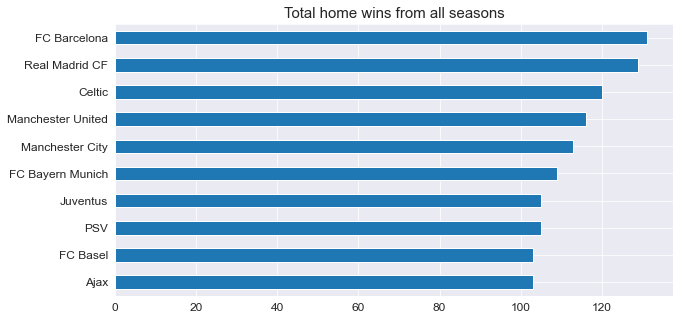

In [32]:
plt.figure(figsize = (12,5))
home_wins[:10].sort_values().plot(kind = 'barh',figsize=(10,5), fontsize=12);
plt.title('Total home wins from all seasons', fontsize=15);

Plot away wins for top 10 teams

In [33]:
away_wins

FC Barcelona              103
Real Madrid CF             99
Celtic                     98
FC Bayern Munich           84
Juventus                   84
                         ... 
Uniao da Madeira            1
CD Tenerife                 1
FC Metz                     1
Tubize                      1
Eintracht Braunschweig      1
Name: away_team, Length: 296, dtype: int64

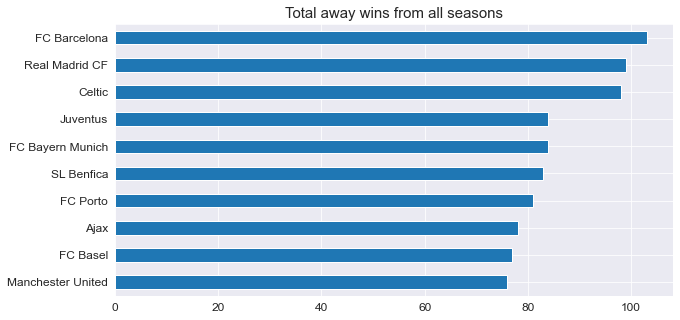

In [34]:
plt.figure(figsize=(10,5));
away_wins[:10].sort_values().plot(kind = 'barh',fontsize=12);
plt.title('Total away wins from all seasons',fontsize=15);

**All wins from all seasons**

In [35]:
total_wins_all_seasons = home_wins + away_wins
total_wins_all_seasons.sort_values(ascending = False)[:10]

FC Barcelona         234.0
Real Madrid CF       228.0
Celtic               218.0
FC Bayern Munich     193.0
Manchester United    192.0
Juventus             189.0
SL Benfica           185.0
FC Porto             183.0
Ajax                 181.0
FC Basel             180.0
dtype: float64

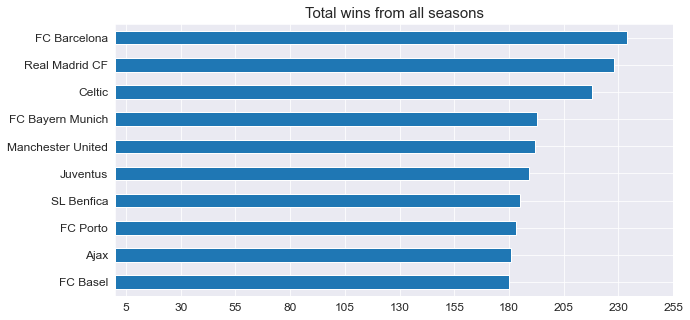

In [36]:
plt.figure(figsize=(10,5));
total_wins_all_seasons.sort_values(ascending = False)[:10][::-1].plot(kind = 'barh',fontsize=12);
plt.title('Total wins from all seasons',fontsize=15);
plt.xticks(range(5,275,25));

#### Second, group the matches by seasons to see the teams through time

In [37]:
grp = df_matches.groupby('season')

**Let's plot an overview on the total home and away goals through all seasons**

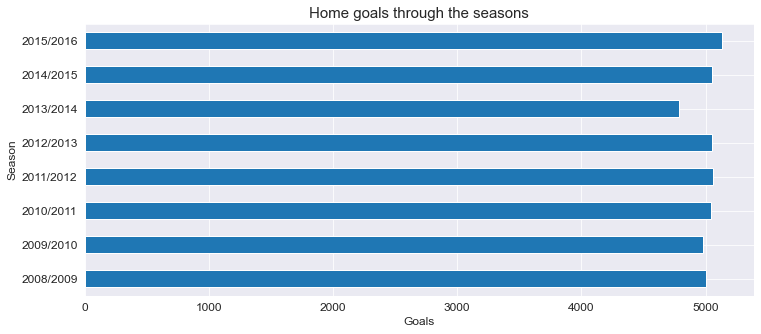

In [38]:
plt.figure(figsize = (12,5));
grp.home_team_goal.sum().plot(kind= 'barh', fontsize = 12);
plt.title('Home goals through the seasons', fontsize = 15);
plt.xlabel('Goals', fontsize = 12);
plt.ylabel('Season', fontsize = 12);

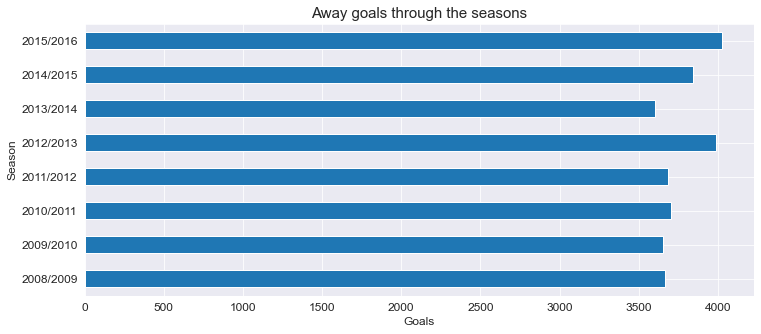

In [39]:
plt.figure(figsize = (12,5));
grp.away_team_goal.sum().plot(kind= 'barh', fontsize = 12);
plt.title('Away goals through the seasons', fontsize = 15);
plt.xlabel('Goals', fontsize = 12);
plt.ylabel('Season', fontsize = 12);

* We can see that teams score more goals at home than away from home
* Season 2013/2014 has low scoring goals compared to the other seasons
* Season 2015/2016 has the highest scoring goals

After the fast overview on goals, now we are examining the winning records

In [40]:
#Group home wins with league and season
grp_home_wins = df_matches[df_matches.home_team_goal > df_matches.away_team_goal].groupby(['league','season'])
#Show total home wins in different seasons
tot_home_wins = grp_home_wins.home_team.value_counts()
tot_home_wins.sort_values(ascending = False).head(15)

league                   season     home_team        
Italy Serie A            2013/2014  Juventus             19
Spain LIGA BBVA          2009/2010  Real Madrid CF       18
England Premier League   2010/2011  Manchester United    18
                         2011/2012  Manchester City      18
Spain LIGA BBVA          2012/2013  FC Barcelona         18
                         2009/2010  FC Barcelona         18
England Premier League   2009/2010  Chelsea              17
Scotland Premier League  2011/2012  Celtic               17
Spain LIGA BBVA          2012/2013  Real Madrid CF       17
England Premier League   2013/2014  Manchester City      17
Spain LIGA BBVA          2011/2012  FC Barcelona         17
England Premier League   2008/2009  Manchester United    16
Netherlands Eredivisie   2009/2010  Ajax                 16
Germany 1. Bundesliga    2008/2009  VfL Wolfsburg        16
Spain LIGA BBVA          2011/2012  Real Madrid CF       16
Name: home_team, dtype: int64

**Plot home wins for different teams in different seasons**

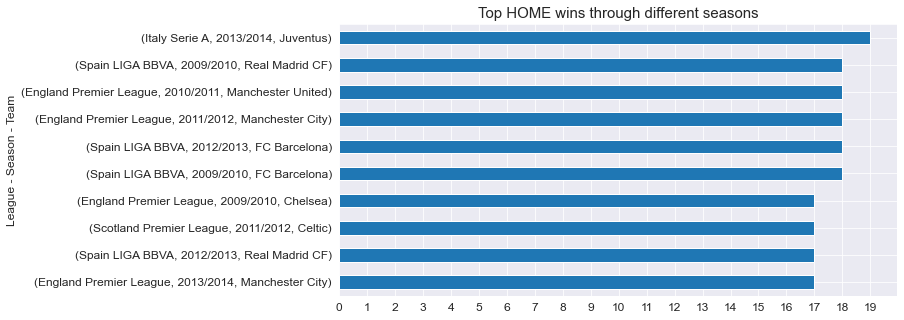

In [41]:
plt.figure(figsize = (10,5))
tot_home_wins.sort_values(ascending=False)[:10][::-1].plot(kind='barh', fontsize = 12)
plt.title('Top HOME wins through different seasons', fontsize = 15)
plt.ylabel('League - Season - Team', fontsize = 12)
#plt.xlabel('HOME wins through the season')
plt.xticks(range(0,20), fontsize = 12);

Now, away wins stats

In [42]:
#Group away wins with league and season and show the total away wins
grp_away_wins = df_matches[df_matches.home_team_goal < df_matches.away_team_goal].groupby(['league','season'])
tot_away_wins = grp_away_wins.away_team.value_counts()
tot_away_wins.sort_values(ascending=False)

league                   season     away_team          
Scotland Premier League  2010/2011  Rangers                16
Spain LIGA BBVA          2011/2012  Real Madrid CF         16
Scotland Premier League  2013/2014  Celtic                 15
France Ligue 1           2015/2016  Paris Saint-Germain    15
Germany 1. Bundesliga    2012/2013  FC Bayern Munich       15
                                                           ..
Poland Ekstraklasa       2008/2009  Cracovia                1
                                    Arka Gdynia             1
Netherlands Eredivisie   2015/2016  SC Cambuur              1
Spain LIGA BBVA          2015/2016  Rayo Vallecano          1
Netherlands Eredivisie   2013/2014  N.E.C.                  1
Name: away_team, Length: 1460, dtype: int64

**Plot away wins for different teams in different seasons**

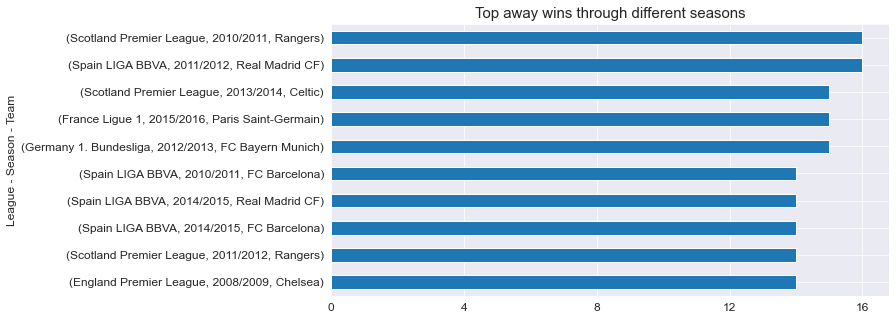

In [43]:
plt.figure(figsize = (10,5))
tot_away_wins.sort_values(ascending=False)[:10][::-1].plot(kind='barh', fontsize = 12)
plt.title('Top away wins through different seasons', fontsize = 15)
plt.ylabel('League - Season - Team', fontsize = 12)
plt.xticks(range(0,17,4), fontsize = 12);

All wins stats

In [44]:
#total wins by summing home and away wins
tot_wins = pd.concat((tot_home_wins,tot_away_wins), axis=1).sum(1, min_count=1).astype(int)
tot_wins.sort_values(ascending=False)[:10]

league                   season                        
Italy Serie A            2013/2014  Juventus               33
Spain LIGA BBVA          2012/2013  FC Barcelona           32
                         2011/2012  Real Madrid CF         32
                         2009/2010  FC Barcelona           31
Scotland Premier League  2013/2014  Celtic                 31
Spain LIGA BBVA          2009/2010  Real Madrid CF         31
                         2014/2015  Real Madrid CF         30
                         2010/2011  FC Barcelona           30
France Ligue 1           2015/2016  Paris Saint-Germain    30
Scotland Premier League  2010/2011  Rangers                30
dtype: int32

**Plot total wins for different teams in different seasons**

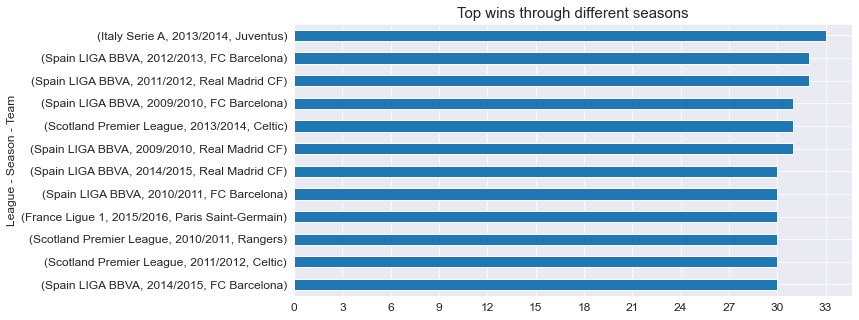

In [45]:
plt.figure(figsize = (10,5))
tot_wins.sort_values(ascending=False)[:12][::-1].plot(kind='barh', fontsize = 12)
plt.title('Top wins through different seasons', fontsize = 15)
plt.ylabel('League - Season - Team', fontsize = 12)
plt.xticks(range(0,36,3), fontsize = 12);

* We can see that Juventus at 2013/2014 season has the most win with total of 33 wins
* Surprisingly Barcelona's dream team at 2009/2010 wasn't the top team as they have 31 wins
* Rangers' (2010/2011) team has the best away record (with Real Madrid's 2011/2012) with 16 wins
* There's no a single English team in the top 12

**Let's examine the English team in different seasons as they didn't manage to be in the top 12**

In [46]:
tot_wins[('England Premier League')].sort_values(ascending = False)[:5]

season                      
2011/2012  Manchester City      28
2008/2009  Manchester United    28
2012/2013  Manchester United    28
2011/2012  Manchester United    28
2009/2010  Manchester United    27
dtype: int32

* Machester teams has wonderful seasons as they achieved 28 wins at multiple seasons
* But other teams had more wins with 30 and more, that's why England wasn't present in the previous graph

**Now, let's explore English teams' seasons in more details**

In [47]:
#Reset the index as we don't want the teams grouped by league and season
data = tot_wins.reset_index()
#Only teams in England
data_England = data.loc[data.league == 'England Premier League']
#Index is the team name
data_England.set_index('level_2', inplace=True)

#Extract the seasons to loop over them
seasons = data_England.season.unique()

#Create column for every season
for season in seasons:
    data_England[season] = data_England[data_England.season == season][0]

<ipython-input-47-a15bb815f53f>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_England[season] = data_England[data_England.season == season][0]


In [48]:
data_England.head()

,league,season,0,2008/2009,2009/2010,2010/2011,2011/2012,2012/2013,2013/2014,2014/2015,2015/2016
level_2,,,,,,,,,,,
Arsenal,England Premier League,2008/2009,20,20.0,23.0,19.0,21.0,21.0,24.0,22.0,20.0
Aston Villa,England Premier League,2008/2009,17,17.0,17.0,12.0,7.0,10.0,10.0,10.0,3.0
Blackburn Rovers,England Premier League,2008/2009,10,10.0,13.0,11.0,8.0,NaN,NaN,NaN,NaN
Bolton Wanderers,England Premier League,2008/2009,11,11.0,10.0,12.0,10.0,NaN,NaN,NaN,NaN
Chelsea,England Premier League,2008/2009,25,25.0,27.0,21.0,18.0,22.0,25.0,26.0,12.0


**Clean the table by droppin league season and "0" columns, also dropping teams which regulated**

In [49]:
data_England.drop(['season',0,'league'], axis = 1,inplace=True)
data_England.drop_duplicates(inplace=True)

E:\anacoda\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-49-92bd30a4f7f3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_England.drop_duplicates(inplace=True)


In [50]:
data_England.isnull()

,2008/2009,2009/2010,2010/2011,2011/2012,2012/2013,2013/2014,2014/2015,2015/2016
level_2,,,,,,,,
Arsenal,False,False,False,False,False,False,False,False
Aston Villa,False,False,False,False,False,False,False,False
Blackburn Rovers,False,False,False,False,True,True,True,True
Bolton Wanderers,False,False,False,False,True,True,True,True
Chelsea,False,False,False,False,False,False,False,False
Everton,False,False,False,False,False,False,False,False
Fulham,False,False,False,False,False,False,True,True
Hull City,False,False,True,True,True,False,False,True
Liverpool,False,False,False,False,False,False,False,False


Nulls here means that the team regulated and wasn't in the top league at all seasons, we don't care about those teams

In [51]:
data_England.dropna(inplace=True)
data_England.head()

<ipython-input-51-43f2d12b912c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_England.dropna(inplace=True)


,2008/2009,2009/2010,2010/2011,2011/2012,2012/2013,2013/2014,2014/2015,2015/2016
level_2,,,,,,,,
Arsenal,20.0,23.0,19.0,21.0,21.0,24.0,22.0,20.0
Aston Villa,17.0,17.0,12.0,7.0,10.0,10.0,10.0,3.0
Chelsea,25.0,27.0,21.0,18.0,22.0,25.0,26.0,12.0
Everton,17.0,16.0,13.0,15.0,16.0,21.0,12.0,11.0
Liverpool,25.0,18.0,17.0,14.0,16.0,26.0,18.0,16.0


In [52]:
#Extract teams names for plotting
teams = data_England.sum(axis = 1).sort_values().index

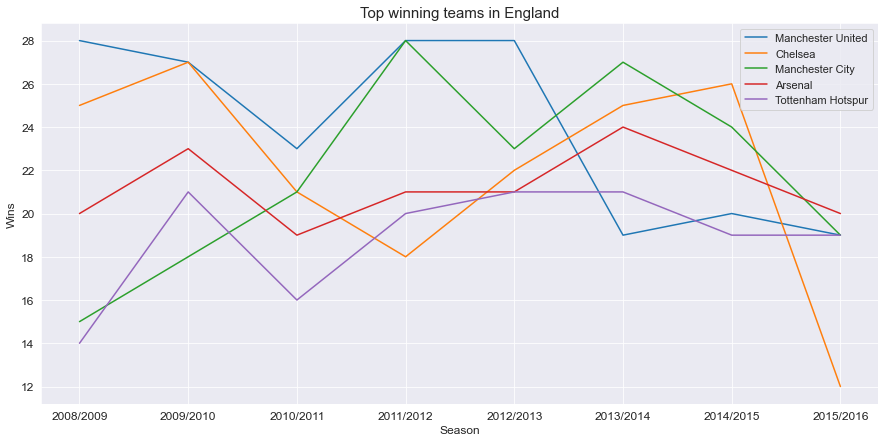

In [53]:
plt.figure(figsize = (15,7));
for team in teams[5:][::-1]:
    plt.plot(data_England.loc[team], label=team)
plt.title("Top winning teams in England", fontsize = 15);
plt.ylabel("Wins", fontsize = 12);
plt.xlabel("Season",fontsize = 12);
plt.xticks(fontsize = 12);
plt.yticks(fontsize = 12);
plt.legend(fontsize = 11, loc ='upper right');

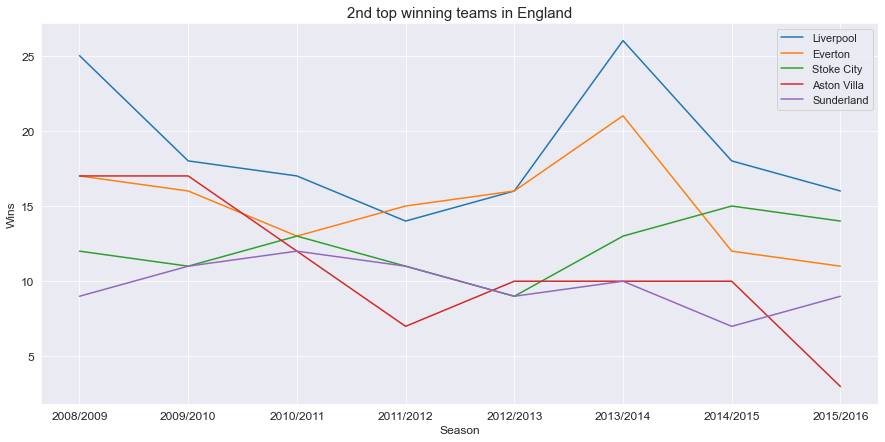

In [54]:
plt.figure(figsize = (15,7));
for team in teams[:5][::-1]:
    plt.plot(data_England.loc[team], label=team)
plt.title("2nd top winning teams in England", fontsize = 15);
plt.ylabel("Wins", fontsize = 12);
plt.xlabel("Season",fontsize = 12);
plt.xticks(fontsize = 12);
plt.yticks(fontsize = 12);
plt.legend(fontsize = 11, loc = 'upper right');

* We can see that top teams in England didn't have consistency 
* No English Team has more than 28 wins
* Manchester United gone downhill after 2012/2013 season when Sir Alex Ferguson left
* Chelsea falled drastically in 2015/2016 season after their curve was going up
* Manchester City records are improved through seasons but still their total wins is low because of 2008/2009 season
* Others were just below 24 goals per season

**After exploring English teams, now it's time to return to all teams and explore their wins through the season**

In [55]:
#Do the same previous steps but for all teams in the world
data = tot_wins.reset_index()
data.set_index('level_2', inplace=True)
seasons = data.season.unique()

for season in seasons:
    data[season] = data[data.season == season][0]
data.head(6)

,league,season,0,2008/2009,2009/2010,2010/2011,2011/2012,2012/2013,2013/2014,2014/2015,2015/2016
level_2,,,,,,,,,,,
Beerschot AC,Belgium Jupiler League,2008/2009,11,11.0,9.0,5.0,9.0,6.0,NaN,NaN,NaN
Club Brugge KV,Belgium Jupiler League,2008/2009,18,18.0,17.0,16.0,19.0,15.0,NaN,17.0,21.0
FCV Dender EH,Belgium Jupiler League,2008/2009,9,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
KAA Gent,Belgium Jupiler League,2008/2009,17,17.0,14.0,17.0,17.0,8.0,3.0,16.0,17.0
KRC Genk,Belgium Jupiler League,2008/2009,15,15.0,8.0,19.0,13.0,15.0,NaN,13.0,14.0
KSV Cercle Brugge,Belgium Jupiler League,2008/2009,14,14.0,11.0,11.0,13.0,3.0,NaN,6.0,NaN


In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1478 entries, Beerschot AC to Lugano
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   league     1478 non-null   object 
 1   season     1478 non-null   object 
 2   0          1478 non-null   int32  
 3   2008/2009  1172 non-null   float64
 4   2009/2010  1196 non-null   float64
 5   2010/2011  1210 non-null   float64
 6   2011/2012  1210 non-null   float64
 7   2012/2013  1222 non-null   float64
 8   2013/2014  1145 non-null   float64
 9   2014/2015  1190 non-null   float64
 10  2015/2016  1171 non-null   float64
dtypes: float64(8), int32(1), object(2)
memory usage: 132.8+ KB


In [57]:
data.isnull().sum()

league         0
season         0
0              0
2008/2009    306
2009/2010    282
2010/2011    268
2011/2012    268
2012/2013    256
2013/2014    333
2014/2015    288
2015/2016    307
dtype: int64

In [58]:
#Cleaning the data by dropping duplicates, nulls and repeated columns
data.drop(['season','league',0], axis = 1,inplace=True)
data.dropna(inplace=True)
data.drop_duplicates(inplace=True)

In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 92 entries, KAA Gent to Grasshopper Club Zürich
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   2008/2009  92 non-null     float64
 1   2009/2010  92 non-null     float64
 2   2010/2011  92 non-null     float64
 3   2011/2012  92 non-null     float64
 4   2012/2013  92 non-null     float64
 5   2013/2014  92 non-null     float64
 6   2014/2015  92 non-null     float64
 7   2015/2016  92 non-null     float64
dtypes: float64(8)
memory usage: 6.5+ KB


Only 92 Teams were in their top leagues from 2008 to 2016 and didn't regulate

**Explore number of wins in all seasons**

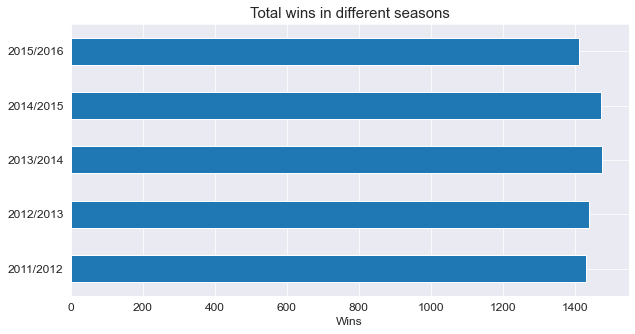

In [60]:
#Total wins per season
wins_by_season= data.sum();
plt.figure(figsize = (10,5))
wins_by_season[3:].plot(kind= 'barh', fontsize = 12);
plt.xlabel('Wins', fontsize = 12);
plt.title("Total wins in different seasons", fontsize = 15);

* 2013/2014 has low number of scoring goals but it's still the top season of number of wins

**Compare wins for each team through the seasons**

In [61]:
#Extract team names for plotting
teams_world = data.sum(axis = 1).sort_values(ascending = False).index

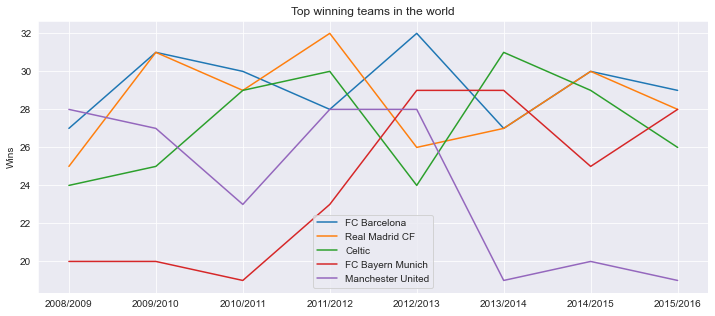

In [62]:
plt.figure(figsize = (12,5));
for team in teams_world[:5]:
    plt.plot(data.loc[team], label=team);
plt.title("Top winning teams in the world");
plt.ylabel("Wins");
plt.legend();

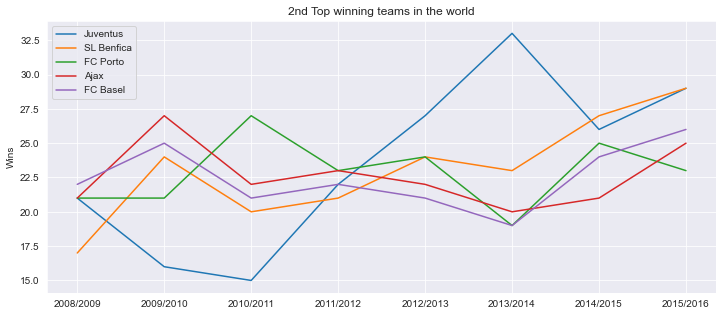

In [63]:
plt.figure(figsize = (12,5));
for team in teams_world[5:10]:
    plt.plot(data.loc[team], label=team)
plt.title("2nd Top winning teams in the world");
plt.ylabel("Wins");
plt.legend();

* Barcelona and Real Madrid are the top teams
* Bayern Munich is the most improved team among the European giants
* Manchester United running in the wrong way in the latest seasons
* Juventus and Benfica are improving through the season
* Porto, Ajax and Basel are consistent in the average area

**Most improved teams through the seasons**

In [64]:
#Calculate the difference in wins between the most recent season and oldest season
imporved_wins = (data['2015/2016'] - data['2008/2009']).sort_values(ascending=False)
print(imporved_wins)
improved_teams = imporved_wins.index 

level_2
Napoli                      13.0
SL Benfica                  12.0
Paris Saint-Germain         11.0
Borussia Dortmund            9.0
Borussia Mönchengladbach     9.0
                            ... 
Girondins de Bordeaux      -12.0
Polonia Bytom              -13.0
Chelsea                    -13.0
Aston Villa                -14.0
FC Zürich                  -17.0
Length: 92, dtype: float64


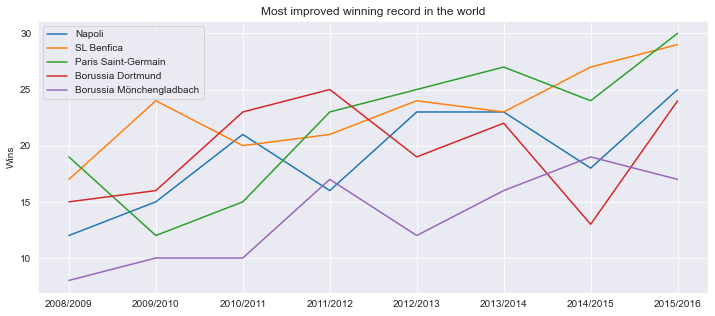

In [65]:
plt.figure(figsize = (12,5));
for team in improved_teams[:5]:
    plt.plot(data.loc[team], label=team);
plt.title("Most improved winning record in the world");
plt.ylabel("Wins");
plt.legend();


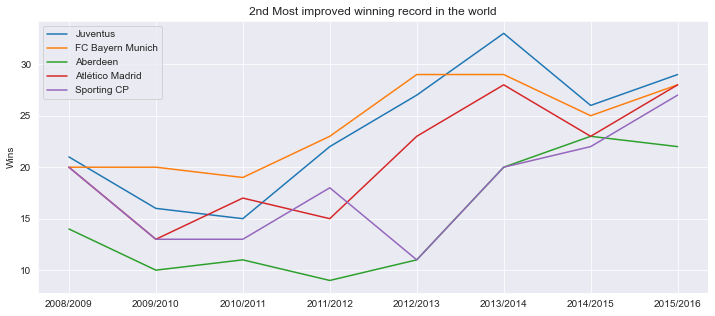

In [66]:
plt.figure(figsize = (12,5))
for team in improved_teams[5:10]:
    plt.plot(data.loc[team], label=team)
plt.title("2nd Most improved winning record in the world");
plt.ylabel("Wins");
plt.legend();


* Napoli, Benfica and PSG are the most improved teams in terms of number of wins

**After wins stats, it's time for goals stats in more details**

In [67]:
#Total home, away, all goals in all seasons for each team
home_goals = df_matches.groupby('home_team').home_team_goal.sum()
away_goals = df_matches.groupby('away_team').away_team_goal.sum()
total_goals = home_goals+away_goals

In [68]:
home_goals.sort_values(ascending= False)

home_team
Real Madrid CF          505
FC Barcelona            495
Celtic                  389
FC Bayern Munich        382
PSV                     370
                       ... 
Trofense                 14
AC Arles-Avignon         14
Feirense                 13
Córdoba CF               12
SpVgg Greuther Fürth     10
Name: home_team_goal, Length: 296, dtype: int64

In [69]:
away_goals.sort_values(ascending= False)

away_team
FC Barcelona               354
Real Madrid CF             338
Celtic                     306
Ajax                       287
PSV                        282
                          ... 
Hércules Club de Fútbol      9
Uniao da Madeira             8
AC Arles-Avignon             7
Reggio Calabria              7
FC Metz                      5
Name: away_team_goal, Length: 296, dtype: int64

In [70]:
total_goals.sort_values(ascending= False)

home_team
FC Barcelona        849
Real Madrid CF      843
Celtic              695
FC Bayern Munich    653
PSV                 652
                   ... 
Amadora              26
Trofense             25
FC Dordrecht         24
Córdoba CF           22
AC Arles-Avignon     21
Length: 296, dtype: int64

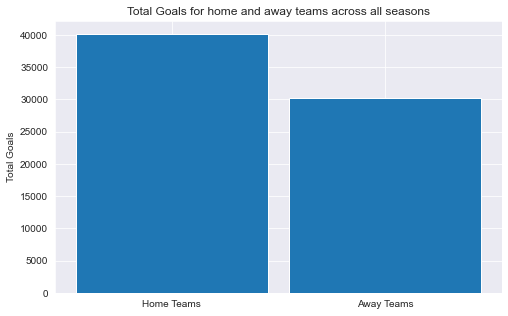

In [71]:
#Plot total goals for home and away teams in all seasons
plt.figure(figsize=(8,5))
plt.bar(x = [2,4],height= [home_goals.sum(),away_goals.sum()], width = 1.8, tick_label= ['Home Teams', 'Away Teams']);
plt.ylabel('Total Goals');
plt.title('Total Goals for home and away teams across all seasons');

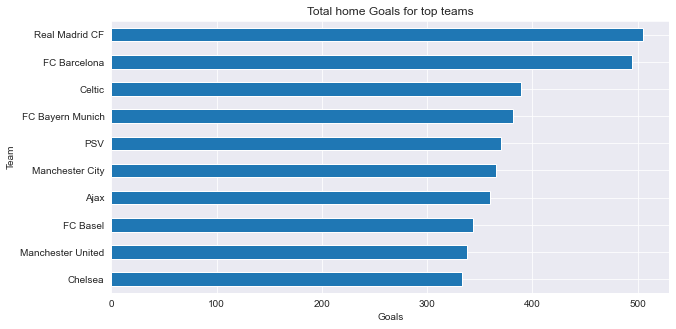

In [72]:
plt.figure(figsize=(10,5));
home_goals.sort_values(ascending= False)[:10][::-1].plot(kind='barh');
plt.ylabel('Team');
plt.xlabel('Goals')
plt.title('Total home Goals for top teams');

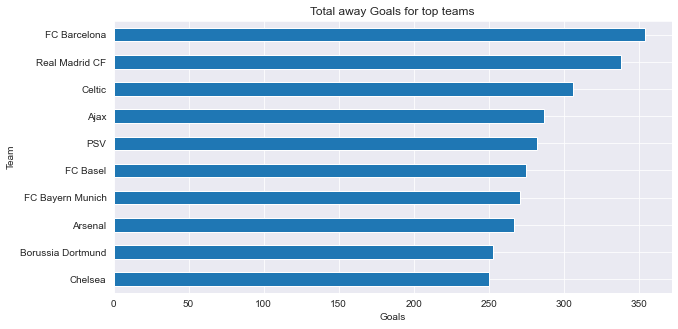

In [73]:
plt.figure(figsize=(10,5));
away_goals.sort_values(ascending= False)[:10][::-1].plot(kind='barh');
plt.ylabel('Team');
plt.xlabel('Goals')
plt.title('Total away Goals for top teams');

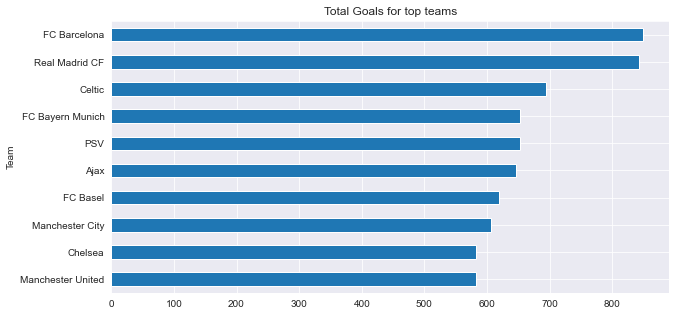

In [74]:
plt.figure(figsize=(10,5));
total_goals.sort_values(ascending= False)[:10][::-1].plot(kind='barh');
plt.ylabel('Team');
#plt.xlabel('Goals')
plt.title('Total Goals for top teams');

* Barcelona and Real Mardid are the top teams in scroing
* Real Madrid are doing better at home and Barcelona are better away from home

In [75]:
#Compare different teams from different eras
#Total home goals
grp_home_goals = df_matches.groupby(['league','season','home_team']).home_team_goal
grp_home_goals.sum().sort_values(ascending=False)[:10]

league                  season     home_team     
Spain LIGA BBVA         2011/2012  FC Barcelona      73
                        2015/2016  Real Madrid CF    70
                        2011/2012  Real Madrid CF    70
England Premier League  2009/2010  Chelsea           68
Spain LIGA BBVA         2015/2016  FC Barcelona      67
                        2012/2013  Real Madrid CF    67
                        2014/2015  Real Madrid CF    65
                                   FC Barcelona      64
Netherlands Eredivisie  2009/2010  Ajax              64
Spain LIGA BBVA         2013/2014  FC Barcelona      64
Name: home_team_goal, dtype: int64

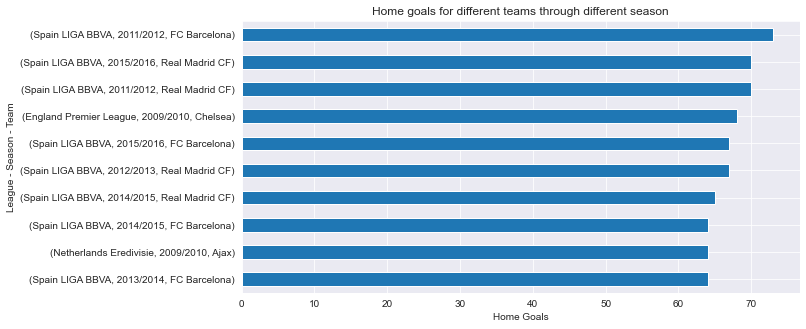

In [76]:
plt.figure(figsize = (10,5));
grp_home_goals.sum().sort_values(ascending=False)[:10][::-1].plot(kind = 'barh');
plt.title('Home goals for different teams through different season');
plt.xlabel('Home Goals');
plt.ylabel('League - Season - Team');

In [77]:
#Away goals from different eras
grp_away_goals = df_matches.groupby(['league','season','away_team']).away_team_goal
grp_away_goals.sum().sort_values(ascending=False)[:10]

league                   season     away_team       
Spain LIGA BBVA          2014/2015  Real Madrid CF      53
                         2012/2013  FC Barcelona        52
Scotland Premier League  2013/2014  Celtic              52
Spain LIGA BBVA          2011/2012  Real Madrid CF      51
                         2010/2011  FC Barcelona        49
England Premier League   2013/2014  Liverpool           48
Netherlands Eredivisie   2015/2016  PSV                 47
Germany 1. Bundesliga    2013/2014  FC Bayern Munich    46
Spain LIGA BBVA          2014/2015  FC Barcelona        46
Netherlands Eredivisie   2012/2013  PSV                 45
Name: away_team_goal, dtype: int64

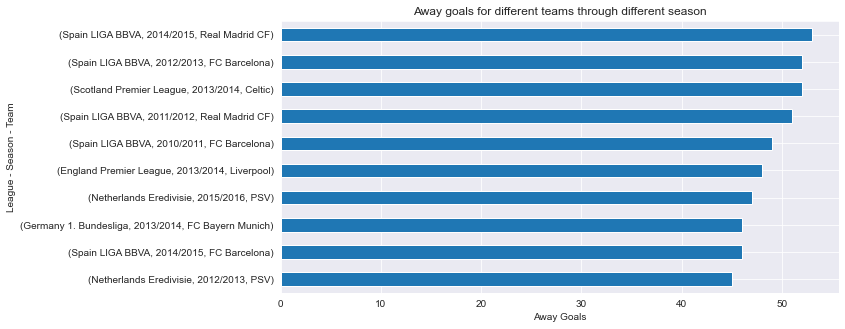

In [78]:
plt.figure(figsize = (10,5));
grp_away_goals.sum().sort_values(ascending=False)[:10][::-1].plot(kind = 'barh');
plt.title('Away goals for different teams through different season');
plt.xlabel('Away Goals');
plt.ylabel('League - Season - Team');

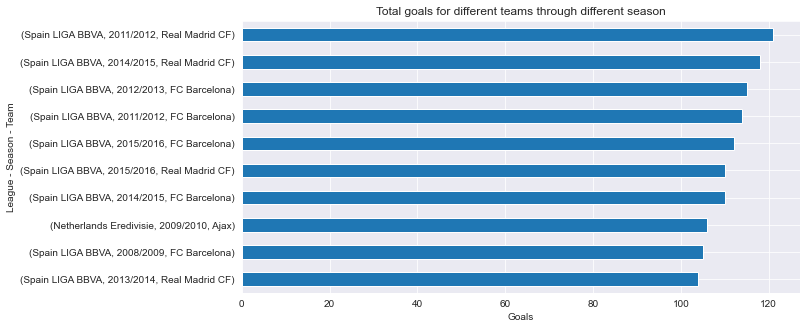

In [79]:
#Total goals from different eras
plt.figure(figsize = (10,5));
tot_goals_season = grp_away_goals.sum() + grp_home_goals.sum();
tot_goals_season.sort_values(ascending=False)[:10][::-1].plot(kind='barh');
plt.title('Total goals for different teams through different season');
plt.xlabel('Goals');
plt.ylabel('League - Season - Team');

* By comparing the different squads, it appears that Real Madrid in 2011/2012 are the most scoring team
* Barcelona's 2008-2009 isn't even in the top 5
* Spanish teams are dominating the top 10 in scoring as only Ajax's 2009/2010 team could make it

**Goals for each team in different seasons**

In [80]:
#Reset the index as we don't data grouped by season and league
data_goals = tot_goals_season.reset_index()
#Index is the team name, ('away_team' was just the default given name for the column)
data_goals.set_index('away_team', inplace=True)
data_goals.head()
#Create a column for each season with the number of wins for each team
seasons = data_goals.season.unique()
for season in seasons:
    data_goals[season] = data_goals[data_goals.season == season][0]

In [81]:
#Clean the table by dropping repeated columns
data_goals.index.name = 'Team'
data_goals.drop(['season',0,'league'], axis = 1, inplace = True)
data_goals.isnull()

,2008/2009,2009/2010,2010/2011,2011/2012,2012/2013,2013/2014,2014/2015,2015/2016
Team,,,,,,,,
Beerschot AC,False,False,False,False,False,True,True,True
Club Brugge KV,False,False,False,False,False,True,False,False
FCV Dender EH,False,True,True,True,True,True,True,True
KAA Gent,False,False,False,False,False,False,False,False
KRC Genk,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...
FC Thun,True,True,False,False,False,False,False,False
FC Vaduz,False,True,True,True,True,True,False,False
FC Zürich,False,False,False,False,False,False,False,False


In [82]:
data_goals.isnull().sum(axis=1)

Team
Beerschot AC               3
Club Brugge KV             1
FCV Dender EH              7
KAA Gent                   0
KRC Genk                   1
                          ..
FC Thun                    2
FC Vaduz                   5
FC Zürich                  0
Grasshopper Club Zürich    0
Lugano                     7
Length: 1478, dtype: int64

In [83]:
#Continue the cleaning byy dropping nulls and duplicates
data_goals.dropna(inplace = True)
data_goals.drop_duplicates(inplace = True)
data_goals

,2008/2009,2009/2010,2010/2011,2011/2012,2012/2013,2013/2014,2014/2015,2015/2016
Team,,,,,,,,
KAA Gent,67.0,49.0,59.0,63.0,33.0,11.0,52.0,56.0
Arsenal,68.0,83.0,72.0,74.0,72.0,68.0,71.0,65.0
Aston Villa,54.0,52.0,48.0,37.0,47.0,39.0,31.0,27.0
Chelsea,68.0,103.0,69.0,65.0,75.0,71.0,73.0,59.0
Everton,55.0,60.0,51.0,50.0,55.0,61.0,48.0,59.0
...,...,...,...,...,...,...,...,...
FC Basel,72.0,90.0,76.0,78.0,61.0,70.0,84.0,88.0
FC Luzern,45.0,66.0,62.0,46.0,41.0,48.0,54.0,59.0
FC Sion,44.0,63.0,47.0,40.0,40.0,38.0,47.0,52.0


In [84]:
all_teams_goals = data_goals.sum(axis=1).sort_values(ascending=False).index

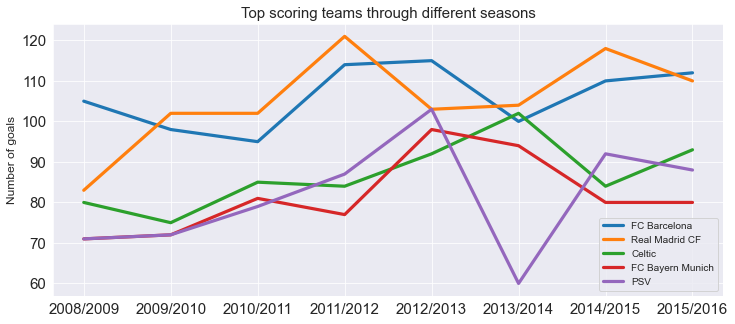

In [85]:
plt.figure(figsize=(12,5));
plt.title("Top scoring teams through different seasons",fontsize=15)
for team in all_teams_goals[:5]:
    data_goals.loc[team].plot(label = team, linewidth =3.2
                              ,fontsize=15);
plt.ylabel("Number of goals",fontsize=12)
plt.legend();

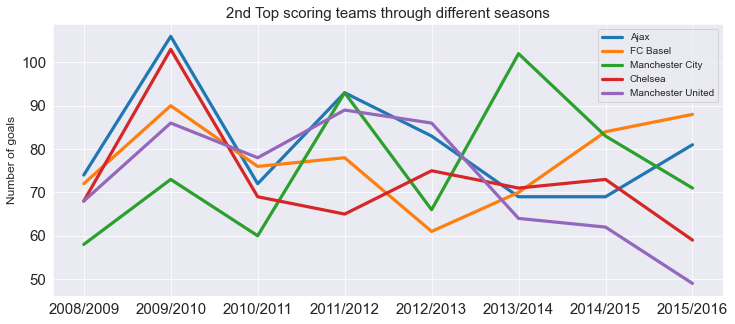

In [86]:
plt.figure(figsize=(12,5));
plt.title("2nd Top scoring teams through different seasons",fontsize=15)
for team in all_teams_goals[5:10]:
    data_goals.loc[team].plot(label = team, linewidth =3.2
                              ,fontsize=15);
plt.ylabel("Number of goals",fontsize=12)
plt.legend();

* Most top teams didn't lose their form and their number of goals through the seasons
* Real Madrid and Barcelona still on top and by large margin
* PSV scoring curve was continuosly improving till 2012-2013 season then went down
* Manchester United curves keeps proving that they need to improve their team again to turn around

**Improved teams in the number of scored goals**

In [87]:
#Difference in goals between 2015/2016 season and 2008/2009 season
diff_goals = data_goals['2015/2016'] - data_goals['2008/2009']
diff_goals.sort_values(ascending= False)
improved_teams = diff_goals.sort_values(ascending= False)
improved_teams

Team
Paris Saint-Germain         53.0
Napoli                      37.0
Sporting CP                 34.0
SL Benfica                  34.0
Borussia Mönchengladbach    28.0
                            ... 
TSG 1899 Hoffenheim        -24.0
Udinese                    -26.0
Aston Villa                -27.0
FC Zürich                  -32.0
VfL Wolfsburg              -33.0
Length: 92, dtype: float64

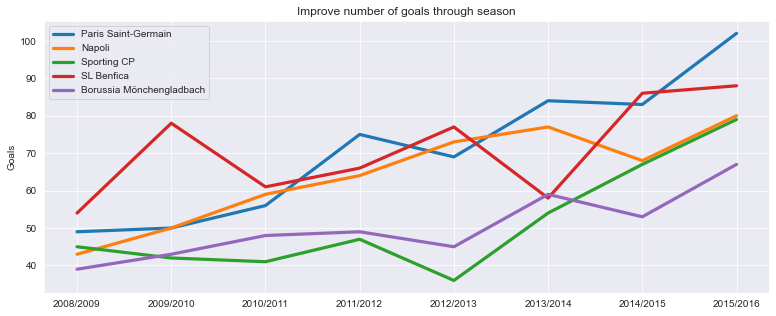

In [88]:
plt.figure(figsize=(13,5));
plt.title("Improve number of goals through season");
for team in improved_teams.index[:5]:
    data_goals.loc[team].plot(label = team, linewidth =3.2);
plt.ylabel("Goals");
plt.legend();

* PSG, Napoli and Sporting are improving their number of goals
* Benfica had the potential to have the largest difference but they keep jumping up and down

**PSG and Napoli are clearly the most improved teams as their # of wins and # of goals jumped up**

### Now after analyzing the matches, the next step is to analyze the players
## Research questions related to players (Wins and Attributes)  
### &emsp;Which players with most wins? <br>&emsp;Which attributes helped winners?

**Birth year**

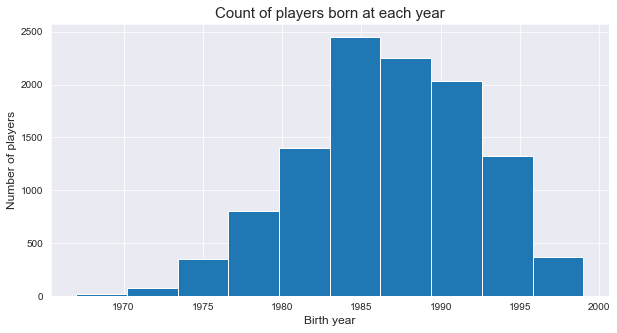

In [89]:
#Plot histogram for year of birth
plt.figure(figsize=(10,5));
plt.hist(pd.DatetimeIndex(df_players['birthday']).year, bins = 10);
plt.ylabel('Number of players',fontsize= 12);
plt.xlabel('Birth year',fontsize= 12);
plt.title("Count of players born at each year", fontsize = 15);

* Most players born between 1985 and 1990

**Let's extract home winners**

In [90]:
sql_q = '''
SELECT 
    M.id as Match_id,
    p1.player_name as H_P1,
    p2.player_name as H_P2,
    p3.player_name as H_P3,
    p4.player_name as H_P4,
    p5.player_name as H_P5,
    p6.player_name as H_P6,
    p7.player_name as H_P7,
    p8.player_name as H_P8,
    p9.player_name as H_P9,
    p10.player_name as H_P10,
    p11.player_name as H_P11

FROM Match AS M 
    LEFT JOIN player AS p1
    ON p1.player_api_id = M.home_player_1 
    
    LEFT JOIN player AS p2
    ON p2.player_api_id = M.home_player_2
    
    LEFT JOIN player AS p3
    ON p3.player_api_id = M.home_player_3
    
    LEFT JOIN player AS p4
    ON p4.player_api_id = M.home_player_4
    
    LEFT JOIN player AS p5
    ON p5.player_api_id = M.home_player_5
    
    LEFT JOIN player AS p6
    ON p6.player_api_id = M.home_player_6
    
    LEFT JOIN player AS p7
    ON p7.player_api_id = M.home_player_7
    
    LEFT JOIN player AS p8
    ON p8.player_api_id = M.home_player_8
    
    LEFT JOIN player AS p9
    ON p9.player_api_id = M.home_player_9
    
    LEFT JOIN player AS p10
    ON p10.player_api_id = M.home_player_10
    
    LEFT JOIN player AS p11
    ON p11.player_api_id = M.home_player_11
    
WHERE M.home_team_goal > M.away_team_goal
'''

df_home_winners = sql_query(sql_q)


**Does player can appear in two positions at different matches or there's a default pattern in the data?**
> Explore the first 5 rows which contains "Ivan Perisic"

In [91]:
df_home_winners[df_home_winners.apply(lambda row: row.astype(str).str.contains('Ivan Perisic').any(), axis=1)].head()

,Match_id,H_P1,H_P2,H_P3,H_P4,H_P5,H_P6,H_P7,H_P8,H_P9,H_P10,H_P11
72,160,Jurgen Sierens,Damir Mirvic,Mladen Lazarevic,Jeremy Huyghebaert,Anthony van Loo,Arturo ten Heuvel,"Stefaan Tanghe,18",Vincent Provoost,Ivan Perisic,Mahamadou Dissa,Sherjill MacDonald
82,177,Jurgen Sierens,Damir Mirvic,Mladen Lazarevic,Jeremy Huyghebaert,Anthony van Loo,"Stefaan Tanghe,18",Vincent Provoost,Ivan Perisic,Joerie Dequevy,Mahamadou Dissa,Sherjill MacDonald
90,191,Jurgen Sierens,Azubuike Oliseh,Mladen Lazarevic,Jeremy Huyghebaert,Anthony van Loo,"Stefaan Tanghe,18",Vincent Provoost,Ivan Perisic,Joerie Dequevy,Mahamadou Dissa,Sherjill MacDonald
150,314,Stijn Stijnen,Carl Hoefkens,Michael Klukowski,Antolin Alcaraz,Gertjan De Mets,Karel Geraerts,Nabil Dirar,Vadis Odjidja-Ofoe,Ivan Perisic,Wesley Sonck,Joseph Akpala
155,321,Stijn Stijnen,Carl Hoefkens,Karel Geraerts,Michael Klukowski,Antolin Alcaraz,Jonathan Blondel,Nabil Dirar,Vadis Odjidja-Ofoe,Ivan Perisic,Joseph Akpala,Dorge Kouemaha


* Any player can appear at different position as Ivan appeared in Player#9 in some matches and in another he played as Player#8

In [92]:
df_home_winners.head()

,Match_id,H_P1,H_P2,H_P3,H_P4,H_P5,H_P6,H_P7,H_P8,H_P9,H_P10,H_P11
0,4,None,None,None,None,None,None,None,None,None,None,None
1,9,None,None,None,None,None,None,None,None,None,None,None
2,10,None,None,None,None,None,None,None,None,None,None,None
3,22,None,None,None,None,None,None,None,None,None,None,None
4,26,None,None,None,None,None,None,None,None,None,None,None


In [93]:
df_home_winners.tail()

,Match_id,H_P1,H_P2,H_P3,H_P4,H_P5,H_P6,H_P7,H_P8,H_P9,H_P10,H_P11
11912,25971,Yvon Mvogo,Florent Hadergjonaj,Milan Vilotic,Steve von Bergen,Jan Lecjaks,Renato Steffen,Denis Zakaria,Leonardo Bertone,Miralem Sulejmani,Alexander Gerndt,Yuya Kubo
11913,25974,Andris Vanins,Elsad Zverotic,Leo Lacroix,Reto Ziegler,Pa Modou Jagne,Laglais Xavier Kouassi,Veroljub Salatic,Ebenezer Assifuah,Chadrac Akolo,Carlitos,Moussa Konate
11914,25975,Daniel Lopar,Silvan Hefti,Alain Wiss,Roy Gelmi,Martin Angha,Mario Mutsch,Everton,Geoffrey Treand,Danijel Aleksic,Yannis Tafer,Sandro Gotal
11915,25977,Vaso Vasic,Moritz Bauer,Alban Pnishi,Levent Guelen,Benjamin Luethi,Kim Kaellstroem,Marko Basic,Yoric Ravet,Shani Tarashaj,Caio,Munas Dabbur
11916,25979,Yvon Mvogo,Florent Hadergjonaj,Milan Vilotic,Steve von Bergen,Jan Lecjaks,Renato Steffen,Denis Zakaria,Alain Rochat,Miralem Sulejmani,Yuya Kubo,Alexander Gerndt


In [94]:
df_home_winners.iloc[9025]

Match_id              19699
H_P1            Tomas Cerny
H_P2           Brian Easton
H_P3        Mark McLaughlin
H_P4          Chris Swailes
H_P5                   None
H_P6          Simon Mensing
H_P7         James McArthur
H_P8         James McCarthy
H_P9              Alex Neil
H_P10       Richard Offiong
H_P11          David Graham
Name: 9025, dtype: object

If we take a look at row #9025, we can see that a match can record some players and miss another, so it's not practical to drop those matches. So, we will stack all columns and count the values for all players

In [95]:
home_winners = df_home_winners.iloc[:,1:].stack().reset_index()[0].value_counts()

In [96]:
home_winners

Marcelo              175
Cristiano Ronaldo    116
Maicon               114
Lionel Messi         108
Danilo               107
                    ... 
Romano Perticone       1
Virgile Reset          1
Gianvito Plasmati      1
Salim Arrache          1
Alexandre Licata       1
Name: 0, Length: 9209, dtype: int64

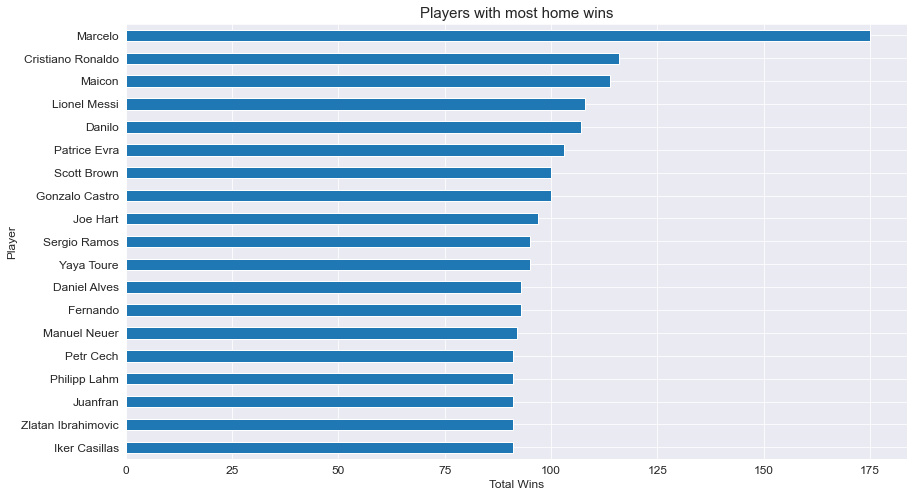

In [97]:
plt.figure(figsize = (14,8))
home_winners.sort_values(ascending = False)[:19][::-1].plot(kind='barh', fontsize = 12)
plt.title('Players with most home wins', fontsize = 15);
plt.ylabel('Player', fontsize = 12);
plt.xlabel('Total Wins', fontsize = 12);

*Marcelo is clearly a winner at home, but let's explore away records too*

**Away winners**

In [98]:
sql_q = '''
SELECT 
    M.id as Match_id,
    p1.player_name as A_P1,
    p2.player_name as A_P2,
    p3.player_name as A_P3,
    p4.player_name as A_P4,
    p5.player_name as A_P5,
    p6.player_name as A_P6,
    p7.player_name as A_P7,
    p8.player_name as A_P8,
    p9.player_name as A_P9,
    p10.player_name as A_P10,
    p11.player_name as A_P11

FROM Match AS M 
    LEFT JOIN player AS p1
    ON p1.player_api_id = M.away_player_1 
    
    LEFT JOIN player AS p2
    ON p2.player_api_id = M.away_player_2
    
    LEFT JOIN player AS p3
    ON p3.player_api_id = M.away_player_3
    
    LEFT JOIN player AS p4
    ON p4.player_api_id = M.away_player_4
    
    LEFT JOIN player AS p5
    ON p5.player_api_id = M.away_player_5
    
    LEFT JOIN player AS p6
    ON p6.player_api_id = M.away_player_6
    
    LEFT JOIN player AS p7
    ON p7.player_api_id = M.away_player_7
    
    LEFT JOIN player AS p8
    ON p8.player_api_id = M.away_player_8
    
    LEFT JOIN player AS p9
    ON p9.player_api_id = M.away_player_9
    
    LEFT JOIN player AS p10
    ON p10.player_api_id = M.away_player_10
    
    LEFT JOIN player AS p11
    ON p11.player_api_id = M.away_player_11
    
WHERE M.home_team_goal < M.away_team_goal
'''

df_away_winners = sql_query(sql_q)
away_winners = df_away_winners.iloc[:,1:].stack().reset_index()[0].value_counts()
away_winners

Marcelo              126
Lionel Messi          86
Scott Brown           84
Cristiano Ronaldo     83
Daniel Alves          80
                    ... 
Robert Malcolm         1
Roderic Filippi        1
Theo Lucius            1
Yannick Cortie         1
Eneko Satrustegui      1
Name: 0, Length: 8521, dtype: int64

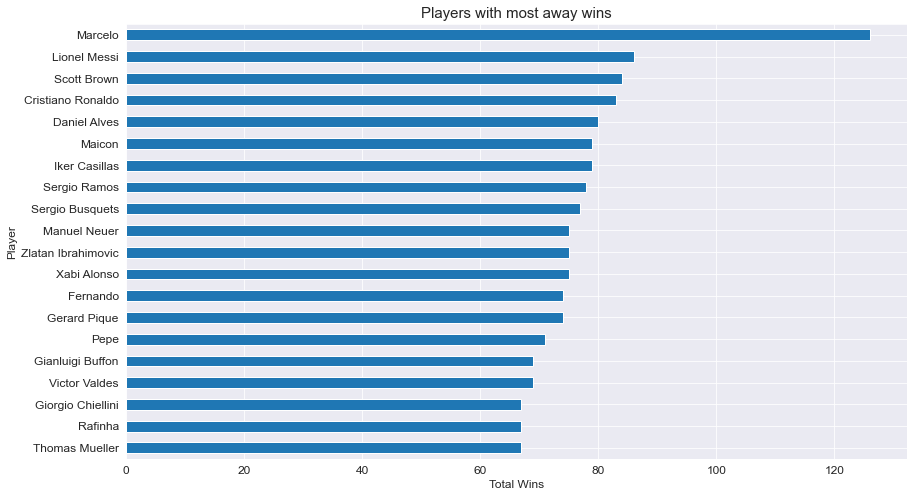

In [99]:
plt.figure(figsize = (14,8))
away_winners.sort_values(ascending = False)[:20][::-1].plot(kind='barh', fontsize = 12)
plt.title('Players with most away wins', fontsize = 15);
plt.ylabel('Player', fontsize = 12);
plt.xlabel('Total Wins', fontsize = 12);

*Marcelo is also the most winning player away from home and by a huge margin*

**Now, we calculate the total wins and after that we focus on the rate of winning instead of the number of wins**

In [100]:
tot_winners = home_winners.add(away_winners, fill_value = 0).astype(int)
tot_winners.sort_values(ascending = False)

Marcelo              301
Cristiano Ronaldo    199
Lionel Messi         194
Maicon               193
Scott Brown          184
                    ... 
Paolo Carbone          1
Pablo Pintos           1
Bobo                   1
Bobley Anderson        1
Raul Lizoain           1
Name: 0, Length: 9654, dtype: int32

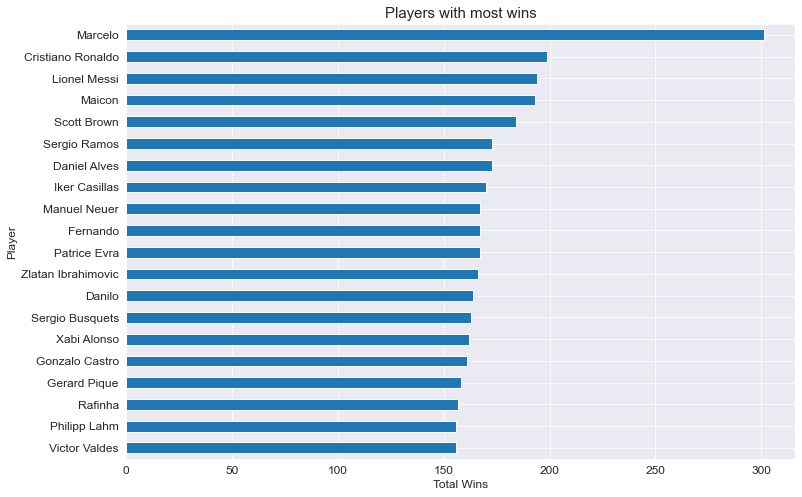

In [101]:
plt.figure(figsize = (12,8))
tot_winners.sort_values(ascending = False)[:20][::-1].plot(kind='barh', fontsize = 12)
plt.title('Players with most wins', fontsize = 15);
plt.ylabel('Player', fontsize = 12);
plt.xlabel('Total Wins', fontsize = 12);

**All players to find the rate of winning**
<br>Pulling all names for all available players in 'Match' table including the draws and losses

In [102]:
sql_q = '''
SELECT 
    M.id as Match_id,
    p1.player_name as H_P1,
    p2.player_name as H_P2,
    p3.player_name as H_P3,
    p4.player_name as H_P4,
    p5.player_name as H_P5,
    p6.player_name as H_P6,
    p7.player_name as H_P7,
    p8.player_name as H_P8,
    p9.player_name as H_P9,
    p10.player_name as H_P10,
    p11.player_name as H_P11,

    p12.player_name as H_P12,
    p13.player_name as H_P13,
    p14.player_name as H_P14,
    p15.player_name as H_P15,
    p16.player_name as H_P16,
    p17.player_name as H_P17,
    p18.player_name as H_P18,
    p19.player_name as H_P19,
    p20.player_name as H_P20,
    p21.player_name as H_P21,
    p22.player_name as H_P22



FROM Match AS M 
    LEFT JOIN player AS p1
    ON p1.player_api_id = M.home_player_1 
    
    LEFT JOIN player AS p2
    ON p2.player_api_id = M.home_player_2
    
    LEFT JOIN player AS p3
    ON p3.player_api_id = M.home_player_3
    
    LEFT JOIN player AS p4
    ON p4.player_api_id = M.home_player_4
    
    LEFT JOIN player AS p5
    ON p5.player_api_id = M.home_player_5
    
    LEFT JOIN player AS p6
    ON p6.player_api_id = M.home_player_6
    
    LEFT JOIN player AS p7
    ON p7.player_api_id = M.home_player_7
    
    LEFT JOIN player AS p8
    ON p8.player_api_id = M.home_player_8
    
    LEFT JOIN player AS p9
    ON p9.player_api_id = M.home_player_9
    
    LEFT JOIN player AS p10
    ON p10.player_api_id = M.home_player_10
    
    LEFT JOIN player AS p11
    ON p11.player_api_id = M.home_player_11
    
    LEFT JOIN player AS p12
    ON p12.player_api_id = M.away_player_1
    
    LEFT JOIN player AS p13
    ON p13.player_api_id = M.away_player_2
    
    LEFT JOIN player AS p14
    ON p14.player_api_id = M.away_player_3
    
    LEFT JOIN player AS p15
    ON p15.player_api_id = M.away_player_4
    
    LEFT JOIN player AS p16
    ON p16.player_api_id = M.away_player_5
    
    LEFT JOIN player AS p17
    ON p17.player_api_id = M.away_player_6
    
    LEFT JOIN player AS p18
    ON p18.player_api_id = M.away_player_7
    
    LEFT JOIN player AS p19
    ON p19.player_api_id = M.away_player_8
    
    LEFT JOIN player AS p20
    ON p20.player_api_id = M.away_player_9
    
    LEFT JOIN player AS p21
    ON p21.player_api_id = M.away_player_10  
        
    LEFT JOIN player AS p22
    ON p22.player_api_id = M.away_player_11
    
'''


df_all_players = sql_query(sql_q)
all_players = df_all_players.iloc[:,1:].stack().reset_index()[0].value_counts()
all_players

Marcelo               513
Ricardo               413
Danilo                350
Gonzalo Castro        347
Juanfran              341
                     ... 
Matias Alustiza         1
Cristian Lobato         1
Daimy Deflem            1
Evangelos Mantzios      1
Tobias Waisapy          1
Name: 0, Length: 10848, dtype: int64

* Now all_players dataframe contains the number of matches for all players
* Marcelo played 100 matches more than Ricarod who is in second place. This explains why he has the most wins

**Calculating winning rate**

In [103]:
win_rate = tot_winners/all_players
win_rate.sort_values(ascending = False)

Junya Tanaka           1.0
Gary McSheffrey        1.0
Marlon Frey            1.0
Sergej Karimov         1.0
Nicolo Barella         1.0
                      ... 
Ziri Hammar            NaN
Zlatko Janjic          NaN
Zoran Josipovic        NaN
Zouhaier Dhaouadhi     NaN
Zurab Khizanishvili    NaN
Name: 0, Length: 10848, dtype: float64

*Some players have a win rate = 1, we need to get into their details now*

In [104]:
for player in win_rate.sort_values(ascending = False).index[:6]:
    print("{}\t\t played {} matches and won {} matches".format(player, all_players[player],tot_winners[player]))

Junya Tanaka		 played 5 matches and won 5 matches
Gary McSheffrey		 played 1 matches and won 1 matches
Marlon Frey		 played 2 matches and won 2 matches
Sergej Karimov		 played 1 matches and won 1 matches
Nicolo Barella		 played 1 matches and won 1 matches
Edson Rivera		 played 1 matches and won 1 matches


* It appears that those players have the opposite case of Marcelo as they played just a few matches and won them

**Recalculating the win rate by only including players with 10 matches or more and 5 wins or more**

In [105]:
all_matches = all_players.loc[all_players >= 10]
all_winners = tot_winners.loc[tot_winners >= 5]
winning_rate = all_winners / all_matches
winning_rate.isnull().sum()

1198

*Nulls are players who met only one condition of the two, will drop them*

In [106]:
winning_rate = winning_rate.sort_values(ascending = False).dropna()
winning_rate

Teofilo Gutierrez           0.950000
Victor Nilsson Lindeloef    0.928571
DaMarcus Beasley            0.916667
Renato Sanches              0.909091
Daniel Hoeegh               0.900000
                              ...   
Jamel Ait Ben Idir          0.113636
Hans Mulder                 0.111111
Marvin Peersman             0.109091
Emmanuel Cascione           0.106383
Anther Yahia                0.102041
Name: 0, Length: 6994, dtype: float64

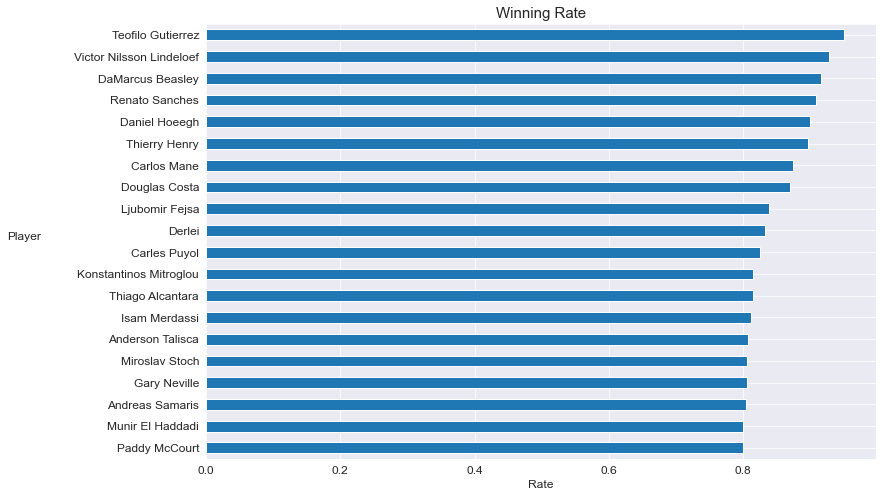

In [107]:
plt.figure(figsize = (12,8))
winning_rate[:20][::-1].plot(kind='barh',fontsize=12)
plt.title('Winning Rate',fontsize=15);
plt.ylabel('Player', rotation=0, labelpad=50,fontsize=12);
plt.xlabel('Rate', fontsize=12);

In [108]:
for player in winning_rate.index[:10]:
    print("{:<25s}:  played {} matches and won {:<3} matches".format(player,all_players[player],tot_winners[player]))

Teofilo Gutierrez        :  played 20 matches and won 19  matches
Victor Nilsson Lindeloef :  played 14 matches and won 13  matches
DaMarcus Beasley         :  played 12 matches and won 11  matches
Renato Sanches           :  played 22 matches and won 20  matches
Daniel Hoeegh            :  played 10 matches and won 9   matches
Thierry Henry            :  played 39 matches and won 35  matches
Carlos Mane              :  played 24 matches and won 21  matches
Douglas Costa            :  played 23 matches and won 20  matches
Ljubomir Fejsa           :  played 31 matches and won 26  matches
Derlei                   :  played 12 matches and won 10  matches


* The player with top winning rate is Teofilo Gutierrez
* Thierry Henry is the player with most matches in the top 10 as he played 39 matches

In [109]:
tot_win_rate = winning_rate[winning_rate > 0.55]
tot_win_rate

Teofilo Gutierrez           0.950000
Victor Nilsson Lindeloef    0.928571
DaMarcus Beasley            0.916667
Renato Sanches              0.909091
Daniel Hoeegh               0.900000
                              ...   
Christian Abbiati           0.550898
Saul Niguez                 0.550725
Manuel Almunia              0.550725
Tim Matavz                  0.550459
Brandao                     0.550388
Name: 0, Length: 599, dtype: float64

**Analyze the top 599 players who have win rate > 0.55**

In [110]:
df_players_att = df_players.merge(df_dic['Player_Attributes'], on = 'player_fifa_api_id')
df_players_att.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183929 entries, 0 to 183928
Data columns (total 46 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   player_fifa_api_id   183929 non-null  int64         
 1   player_name          183929 non-null  object        
 2   birthday             183929 non-null  datetime64[ns]
 3   height               183929 non-null  float64       
 4   weight               183929 non-null  int64         
 5   id                   183929 non-null  int64         
 6   player_api_id        183929 non-null  int64         
 7   date                 183929 non-null  object        
 8   overall_rating       183142 non-null  float64       
 9   potential            183142 non-null  float64       
 10  preferred_foot       183142 non-null  object        
 11  attacking_work_rate  180748 non-null  object        
 12  defensive_work_rate  183142 non-null  object        
 13  crossing      

**Filter the attributes to only the top 600 players**

In [111]:
df_players_att = df_players_att.loc[df_players_att['player_name'].isin(tot_win_rate.index)]
df_players_att['date'] = pd.to_datetime(df_players_att['date'])
df_players_att.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14272 entries, 1925 to 183643
Data columns (total 46 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   player_fifa_api_id   14272 non-null  int64         
 1   player_name          14272 non-null  object        
 2   birthday             14272 non-null  datetime64[ns]
 3   height               14272 non-null  float64       
 4   weight               14272 non-null  int64         
 5   id                   14272 non-null  int64         
 6   player_api_id        14272 non-null  int64         
 7   date                 14272 non-null  datetime64[ns]
 8   overall_rating       14225 non-null  float64       
 9   potential            14225 non-null  float64       
 10  preferred_foot       14225 non-null  object        
 11  attacking_work_rate  14152 non-null  object        
 12  defensive_work_rate  14225 non-null  object        
 13  crossing             14225 

In [112]:
df_players_att.head()

,player_fifa_api_id,player_name,birthday,height,weight,id,player_api_id,date,overall_rating,potential,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
1925,193768,Adam Matthews,1992-01-13,177.8,157,1926,170593,2016-06-09,73.0,77.0,...,69.0,50.0,73.0,75.0,74.0,6.0,15.0,12.0,6.0,14.0
1926,193768,Adam Matthews,1992-01-13,177.8,157,1927,170593,2016-06-02,73.0,77.0,...,69.0,50.0,73.0,75.0,74.0,6.0,15.0,12.0,6.0,14.0
1927,193768,Adam Matthews,1992-01-13,177.8,157,1928,170593,2016-05-19,73.0,77.0,...,69.0,50.0,73.0,75.0,74.0,6.0,15.0,12.0,6.0,14.0
1928,193768,Adam Matthews,1992-01-13,177.8,157,1929,170593,2016-03-10,73.0,77.0,...,69.0,50.0,73.0,75.0,74.0,6.0,15.0,12.0,6.0,14.0
1929,193768,Adam Matthews,1992-01-13,177.8,157,1930,170593,2015-12-17,73.0,77.0,...,69.0,50.0,73.0,75.0,74.0,6.0,15.0,12.0,6.0,14.0


*Attributes are recorded at different dates, I'll average them for each player*

In [113]:
df_att_group = df_players_att.groupby('player_name')

**Explore physical characteristics of players**

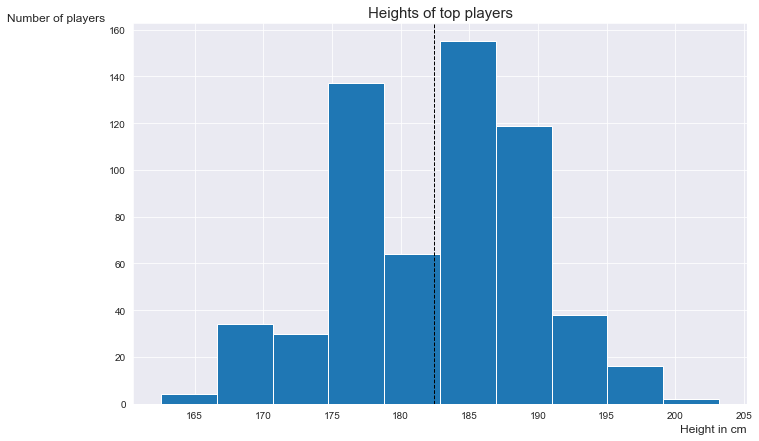

In [114]:
plt.figure(figsize = (11,7));
plt.hist(df_players_att.groupby('player_name')[['height']].mean());
#Plot the average on the histogram
plt.axvline(df_att_group[['height']].mean().mean()[0], color='k', linestyle='dashed', linewidth=1)
plt.title('Heights of top players', fontsize = 15);
plt.xlabel('Height in cm', fontsize = 12, loc = 'right');
plt.ylabel('Number of players', fontsize = 12, loc = 'top', rotation = 0);

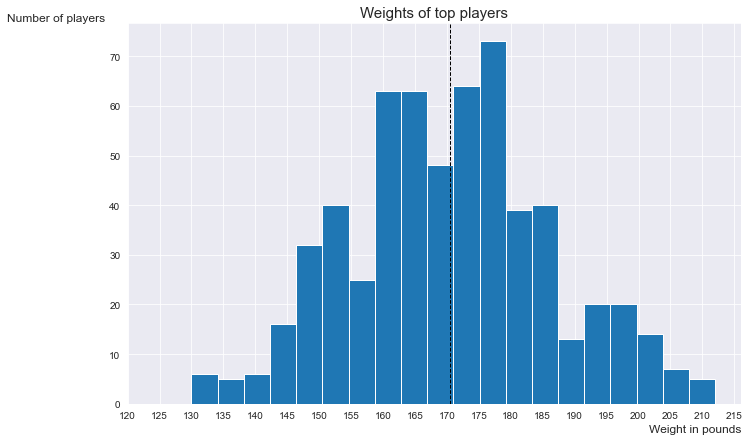

In [115]:
plt.figure(figsize = (11,7));
plt.hist(df_players_att.groupby('player_name')[['weight']].mean(), bins = 20);
#Plot the average on the histogram
plt.axvline(df_att_group[['weight']].mean().mean()[0], color='k', linestyle='dashed', linewidth=1)
plt.xticks(range(120,220,5))
plt.title('Weights of top players', fontsize = 15);
plt.xlabel('Weight in pounds', fontsize = 12, loc = 'right');
plt.ylabel('Number of players', fontsize = 12, rotation = 0, loc = 'top');

* Mean weight is 170 lb 
* Mean height is 182 cm

**Explore Fifa ratings of players**

*Mean overall rating of the players in FIFA*

In [116]:
df_att_group.overall_rating.mean().mean()

74.0904242549017

*Top Players in FIFA*

In [117]:
df_att_group.overall_rating.mean().sort_values(ascending = False)[:20]

player_name
Lionel Messi              92.192308
Cristiano Ronaldo         91.280000
Franck Ribery             88.458333
Andres Iniesta            88.320000
Zlatan Ibrahimovic        88.285714
Arjen Robben              87.840000
Xavi Hernandez            87.636364
Wayne Rooney              87.222222
Iker Casillas             86.954545
Philipp Lahm              86.733333
David Silva               86.538462
Robin van Persie          86.473684
Cesc Fabregas             86.193548
Sergio Aguero             86.114286
Carles Puyol              85.888889
Manuel Neuer              85.862069
Sergio Ramos              85.789474
Carlos Tevez              85.789474
Gianluigi Buffon          85.774194
Bastian Schweinsteiger    85.653846
Name: overall_rating, dtype: float64

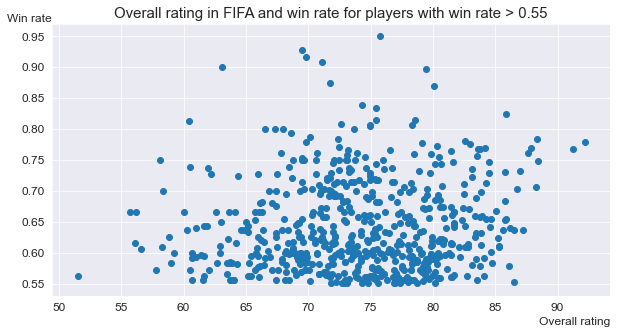

In [118]:
y_win_rate = winning_rate[:599];
x_overall_rating = df_att_group.overall_rating.mean()[y_win_rate.index];
plt.figure(figsize = (10,5));
plt.scatter(y = y_win_rate, x = x_overall_rating);
plt.title('Overall rating in FIFA and win rate for players with win rate > 0.55', fontsize = 15);
plt.ylabel('Win rate', fontsize = 12, rotation = 0, labelpad = -30, loc = 'top');
plt.xlabel('Overall rating', fontsize = 12, loc = 'right');
plt.xticks(fontsize = 12);
plt.yticks(fontsize = 12);

* Top players in FIFA have a win rate between 0.75 and 0.8, While players with high win rate in real matches don't have a high rate in FIFA
* There's no clear correlation between the overall rating and the win rate

*All attributes with win rate*

```
plotcols = df_players_att.select_dtypes(['float64']).columns
y_win_rate = winning_rate[:599];

for pltcol in plotcols:
    x_overall_rating = df_att_group[pltcol].mean()[y_win_rate.index];
    temp_col_label = pltcol.replace("_", " ").title()
    plt.figure(figsize = (10,5));
    plt.scatter(y = y_win_rate, x = x_overall_rating);
    plt.title('{} in FIFA and win rate for players with win rate > 0.55'.format(temp_col_label), fontsize = 15);
    plt.ylabel('Win rate', fontsize = 12, rotation = 0, labelpad = -10, loc = 'top');
    plt.xlabel('{}'.format(temp_col_label), fontsize = 12, loc = 'right');
    plt.xticks(fontsize = 12);
    plt.yticks(fontsize = 12);
    #plt.close()
```

* Graphs don't show any correlation so it's better to hide them here

**It's better to analyze the attributes in Fifa without the win rate**

*Top 30 overall rating in Fifa*

In [119]:
#Join players table with player_attributes to get player name with his fifa rates
df_players_att = df_players.merge(df_dic['Player_Attributes'], on = 'player_fifa_api_id')
#Get only top 30 mean overall ranking in Fifa
top_30_fifa = df_players_att.groupby("player_name").overall_rating.mean().sort_values(ascending = False)[:30]
df_players_att = df_players_att.loc[df_players_att['player_name'].isin(top_30_fifa.index)]
df_att_group = df_players_att.groupby('player_name')

<ipython-input-120-32437b463762>:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize = (10,5));


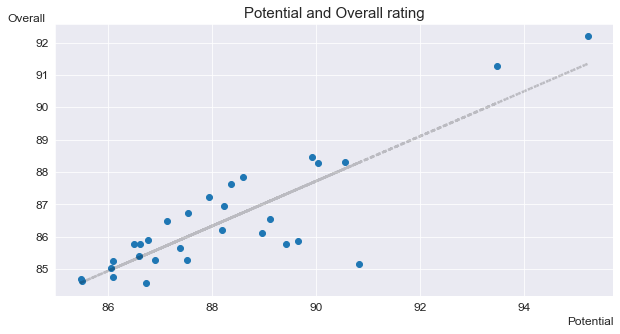

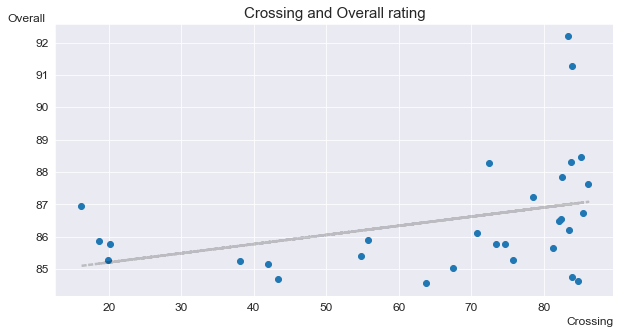

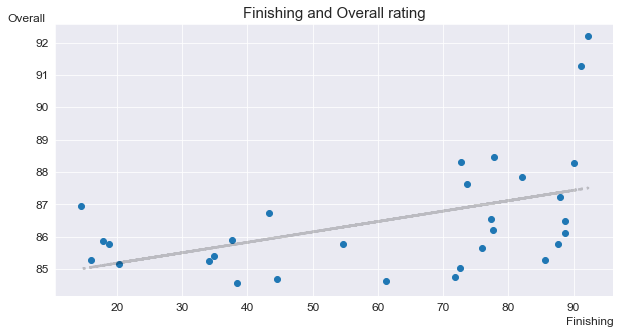

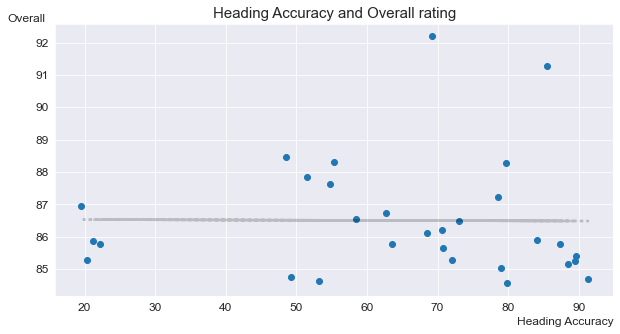

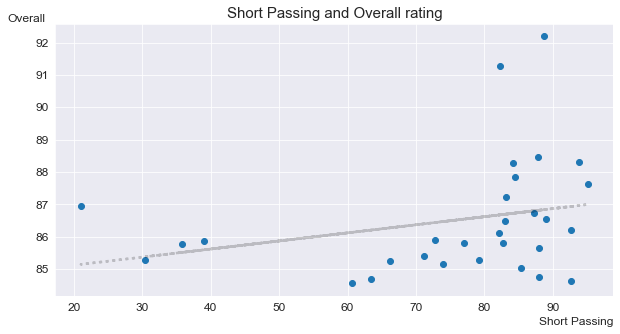

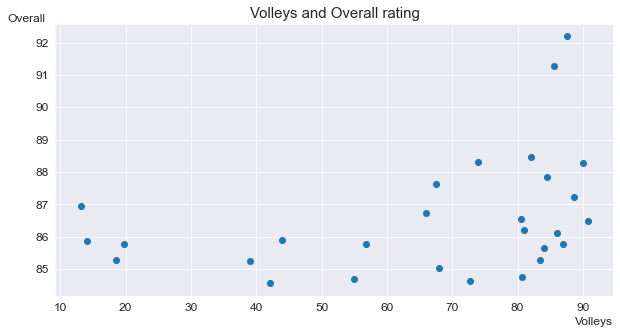

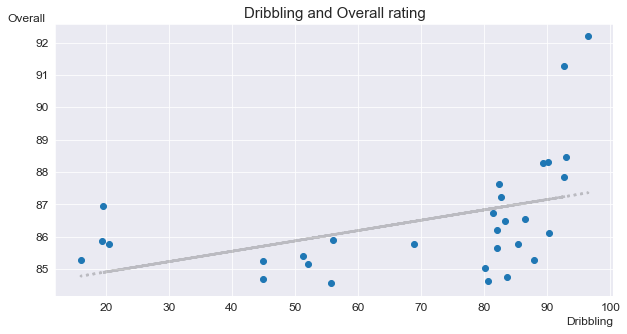

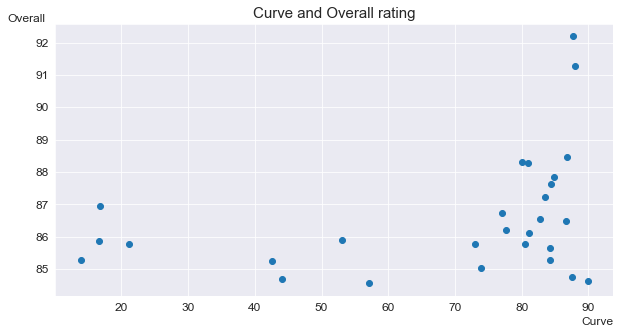

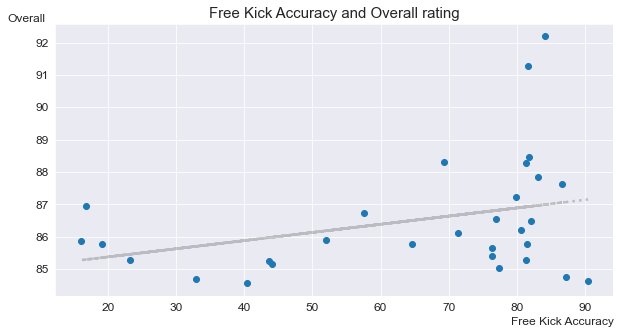

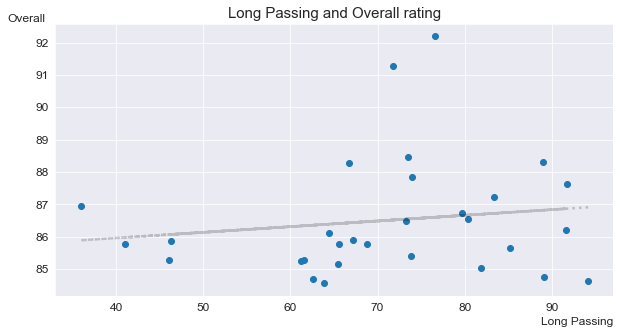

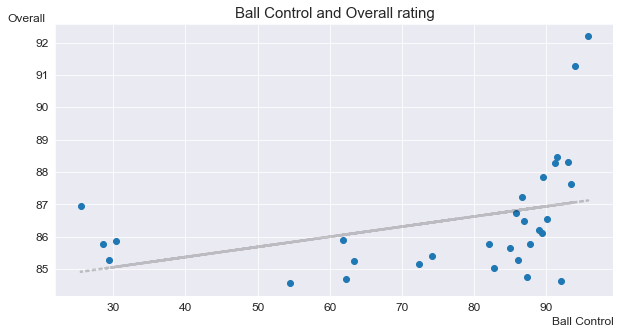

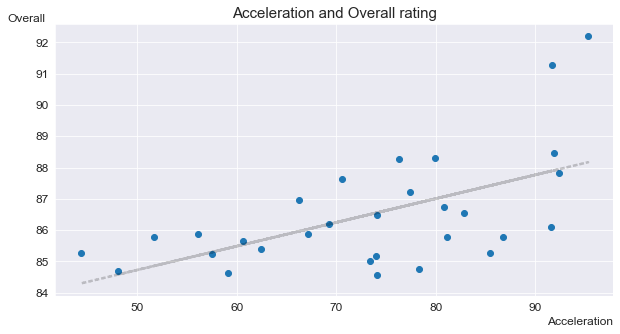

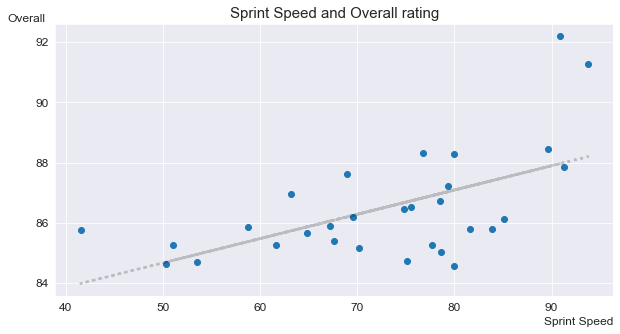

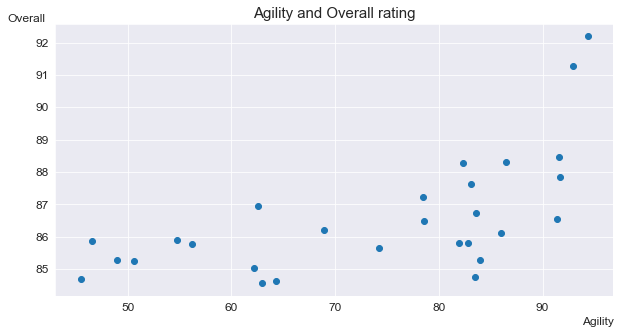

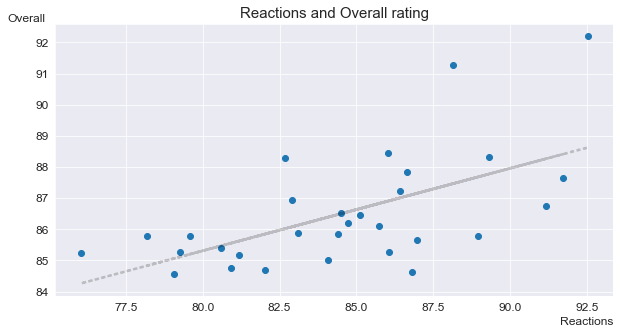

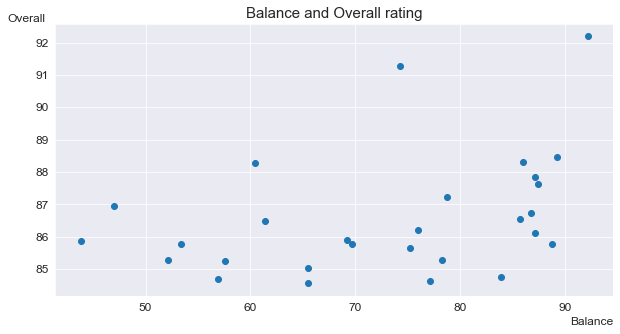

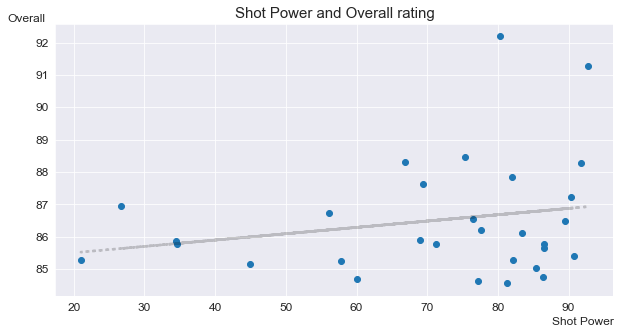

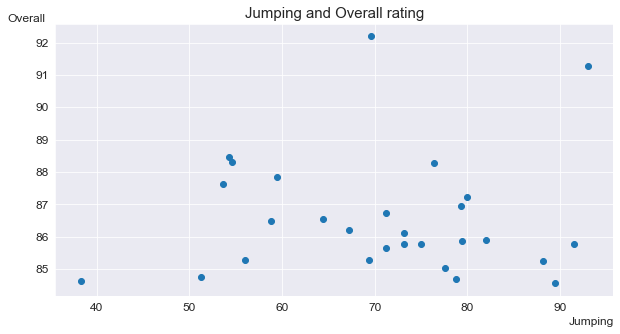

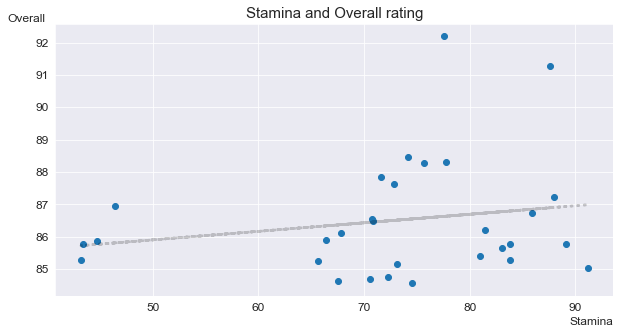

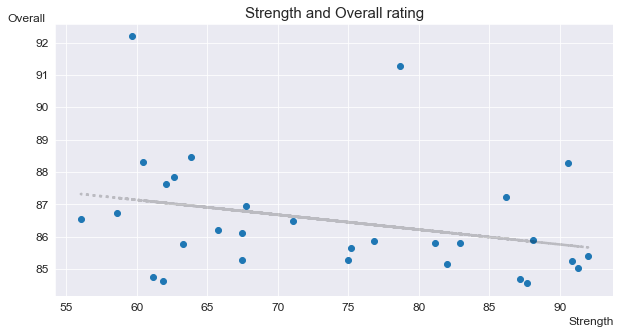

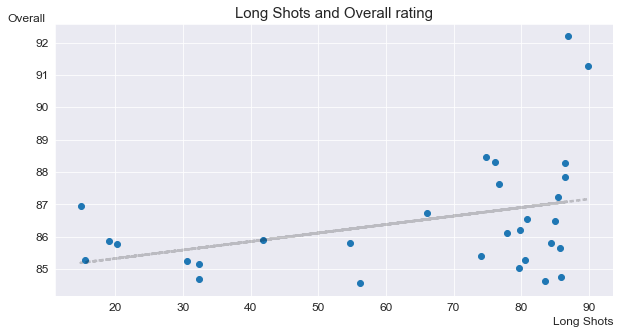

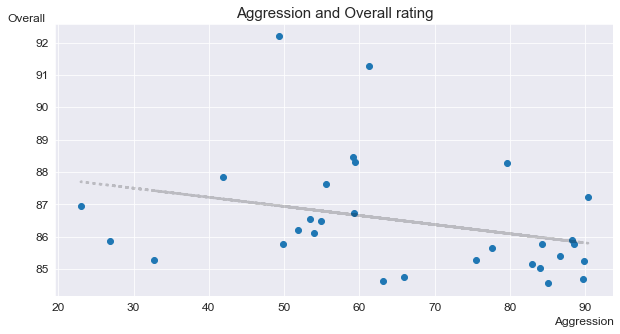

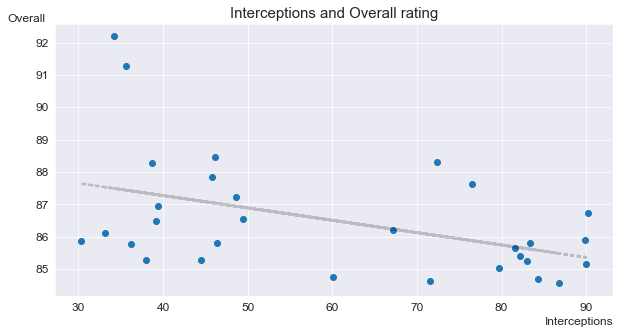

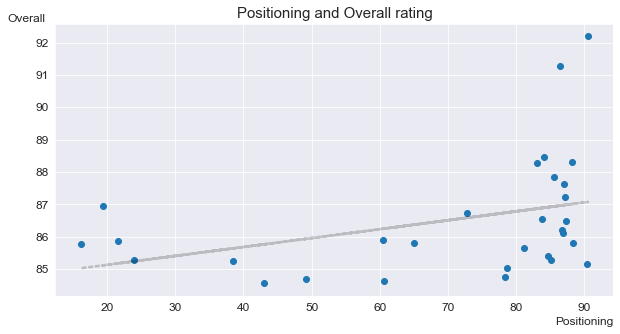

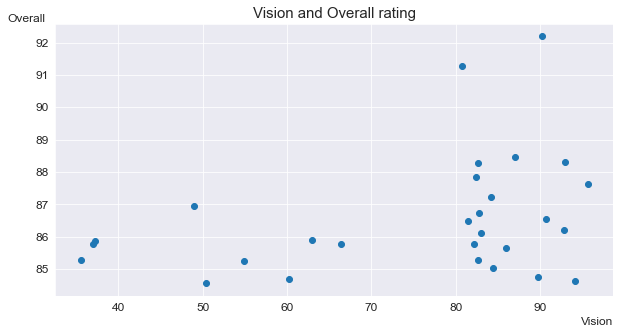

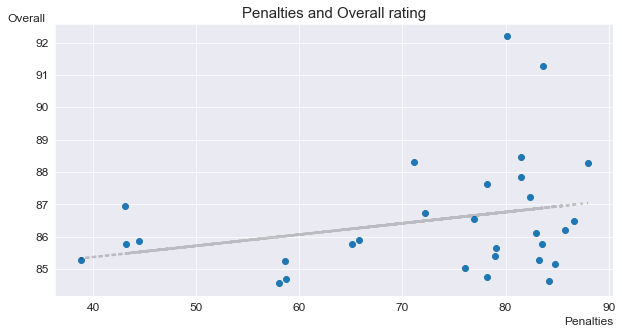

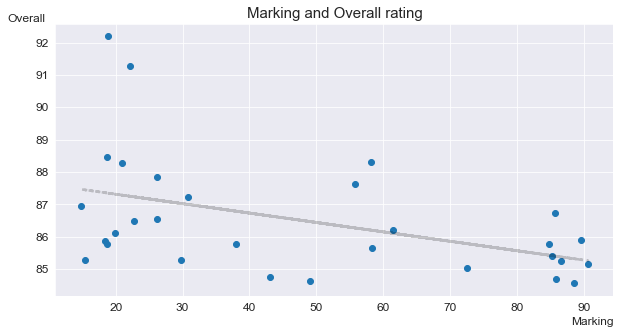

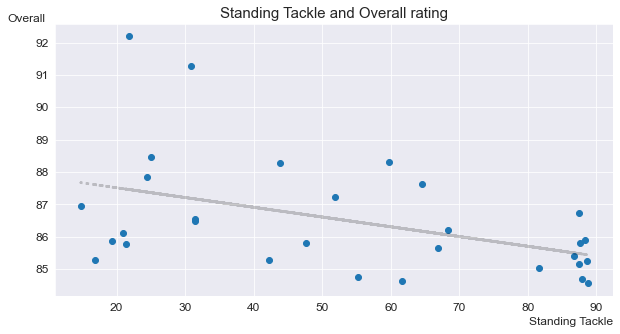

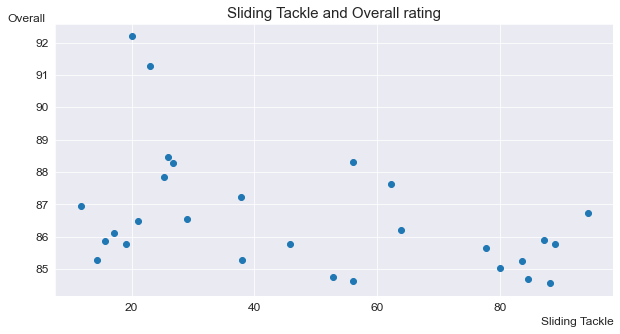

In [120]:
#Plot columns with data type float64 only
#Neglecting gk attributes as most players are outfield players
plotcols = df_players_att.select_dtypes(['float64']).columns[2:-5]
y_ovrl_rate = df_att_group['overall_rating'].mean()

for pltcol in plotcols:
    x_att_rate = df_att_group[pltcol].mean()
    temp_col_label = pltcol.replace("_", " ").title()
    plt.figure(figsize = (10,5));
    plt.scatter(y = y_ovrl_rate, x = x_att_rate);
    plt.title('{} and Overall rating'.format(temp_col_label), fontsize = 15);
    plt.ylabel('Overall', fontsize = 12, rotation = 0, labelpad = -10, loc = 'top');
    plt.xlabel('{}'.format(temp_col_label), fontsize = 12, loc = 'right');
    plt.xticks(fontsize = 12);
    plt.yticks(fontsize = 12);
    #Find a line to fit the points
    try:
        m, b = np.polyfit(x_att_rate, y_ovrl_rate, 1)
    #If svf can't be applied, continue without drawing any lines
    except:
        continue
    plt.plot(x_att_rate, x_att_rate*m + b, color = 'black',
         linewidth = 2.5, alpha = 0.2, linestyle = "dotted");

* Potential is the most correlated attribute with overall rating, this makes sense as in Fifa the potential is in the range of overall rating +- 10
* Accelereation, sprint speed, reactions, penalties, positioning and long shots have positive correlation with overall rating
* Interception, marking and standing tackle have negative correlation with overall rating

<a id='conclusions'></a>
## Conclusions

- **Regrading teams**
> *Noted that we don't have the teams international records, these matches are only from local league and the normal football season has two more competations (the cup and European comp.)*
> <br>
> * Juventus has the most wins in a single season at 2013-2014 with 33 wins
> * Barcelona has the highest total wins in all seasons with 234
> * Barceona, Real Madrid and Celtic are the most consistent teams
> * PSG and Napoli are the most improved teams in terms of wins and goals scored 

- **Regrading players**
> *Noted that we are missing multiple line ups*
> <br>
> * Marcelo has the most wins with a total of 301, Cristiano Ronaldo is second with 199 wins and Lionel Messi is third with 194 wins
> * Teofilo Gutierrez has the highest winning rate of 0.95 from 20 matches, Lindeloef is the second with rate of 0.928 from 14 matches
> * Accelereation, sprint speed and reactions are the most positive correlated attributes with overall rating in Fifa, which means the faster the player, the higher his overall rating

- **For future research**
> * Collecting data about who scored the goals
> * Complete Fifa attributes for missing players
> * Get full line ups for all matches
> * Record more competations like cups, UCL and UEL

# Links
> * https://kbehrends.netlify.app/post/2017/12/soccerdb-schema-diagrams/
> * http://www.football-data.co.uk/notes.txt
> * https://stackoverflow.com/questions/305378/list-of-tables-db-schema-dump-etc-using-the-python-sqlite3-api
> * https://stackoverflow.com/questions/39616077/is-there-any-difference-between-closing-a-cursor-or-a-connection-in-sqlite
> * https://stackoverflow.com/questions/16180946/drawing-average-line-in-histogram-matplotlib
> * https://stackoverflow.com/questions/34734572/tabs-in-print-are-not-consistent-python